## steps:
1. create track_videoX.csv
2. create tracks_with_label_videoX.csv
3. clip to calculate speed, label with average speed

## 1. Create 'track_videoX.csv'

In [168]:
##  This cell of code is the same as src/trackData_generation_optical_flow.py
## need to put in the ../src folder
## output /result/opticalFlow_tracks_jinshajiangRoad.csv' for next step of processing
'''
1.0 generate /result/opticalFlow_tracks_jinshajiangRoad.csv
'''
import numpy as np
import cv2 as cv
import os
import pandas as pd
import sys
sys.path.append('../models')
sys.path.append('../src')
from mlp import load_model
from my_utils import mask_rect
import torch
import time
import re

root = os.path.join(os.environ['HOME'],'./Documents/datasets/traffic/sh')

file_name = '1_Relaxing_highway_traffic.mp4'  ## both lab and local
# file_name = '2_traffic_shanghai_guangfuxilu_202308031400_720.mp4'
# file_name = '3_traffic_shanghai_jinshajianglu_202308050815_720.mp4'
# file_name = '4_traffic_shanghai_changninglu_202308050830_720.mp4'
# file_name = 'traffic_shanghai_guangfuxilu_202307311730_720.mp4'
# file_name = 'traffic_shanghai_guangfuxilu_202308050700_720.mp4'

video_sequence = re.findall(r'([0-9]*)_.',file_name)[0]

device_mlp = 'cuda'
model = load_model(device = device_mlp)
model.eval().to(device_mlp)

# ################# option1, on demand mask ####################
# mask_blank = cv.imread('../image/mask_360x640.png')  # 360x640.png, _500x400
# # mask_blank =  cv.imread('./image/mask_180x320_rightside.png')  # 360x640.png, 180x320_rightside, _500x400
# mask_resized = cv.resize(mask_blank, sizes, interpolation=cv.INTER_CUBIC)

################## option2:  mask by rectangle ###############
upper_left = (0.2,0.0)  # in percentage
lower_right = (0.9,0.5)  ## in percentage
mask_resized= mask_rect((720,1080),upper_left,lower_right) ##  720 *1080, 720*1980?
##############################################################
to_mask = False

#################above: make rect mask##############################

input_video = os.path.join(root, file_name)
# input_video = os.path.join(root, 'Road traffic video for object detection and tracking - 2020 Challenge_720.mp4')
# input_video = os.path.join(root, 'Traffic count, monitoring with computer vision. 4K, UHD, HD..mp4')
cap = cv.VideoCapture(input_video)
# out_video_name =os.path.join(root, 'track_out_video.mp4')   #when need save output video use it

# params for ShiTomasi corner detection
feature_params = dict(maxCorners=50,
                      qualityLevel=0.1,
                      minDistance=3,
                      blockSize=3)
# Parameters for lucas kanade optical flow
# maxLevel
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors 产生随机的颜色值
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
(is_opened, old_frame) = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

# out_fps = 30.0
fourcc = cv.VideoWriter_fourcc('M', 'P', '4', '2')
sizes = (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
print(sizes)
# out = cv.VideoWriter(out_video_name, fourcc, out_fps, sizes)

speed = 0


n=0
speed_list , fps_list = [] , []
y_pred = 5
old_new = pd.DataFrame(columns=['item', 'old_x', 'old_y', 'new_x', 'new_y', 'round'])
item_list, old_x_list, old_y_list, new_x_list, new_y_list = [], [], [], [], []
round_list = [] ## for data processing
round=0
alpha = 0.5*360

def distance(x_old, y_old, x_new, y_new):
    return np.sqrt((x_new-x_old)**2+(y_new-y_old)**2)

y_pred = 0

while True:
    start = time.time()
    ## puase and resuem
    key1 = cv.waitKey(2)
    if key1 == ord('p'):
        while (True):
            key2 = cv.waitKey(5)
            if key2 == ord('o'):
                break ## brek the pause loop
    
    
    n+=1
    if n% 120 == 0 :  ## reset every 4 secs.
        round+=1
        mask = np.zeros_like(old_frame)  ## every 120 frames refresh the tracking line
        p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)  ## reset the p0 , start a new calculation


    (is_opened, frame) = cap.read()
    if not is_opened: break ## end of video playing
    if to_mask: frame = frame * mask_resized
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # p1, st, err = cv.cuda.SparsePyrLKOpticalFlow(old_gray, frame_gray, p0, None, **lk_params)
    #     print(st)
    # flow = cv.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    #     print(good_new)
    ## draw the tracks
    threshold_pix_dist= 1500  ## filter outliers
    spds=[]  ## in these 2 frames

    for i, (new, old) in enumerate(zip(good_new, good_old)):
        # print(i,':', new,old)
        # print('Total points:', len(good_new))
        item_list.append(i)
        old_x_list.append(old[0])
        old_y_list.append(old[1])
        new_x_list.append(new[0])
        new_y_list.append(new[1])
        round_list.append(round)

        # alpha= ((new[0]-00)/520)  ## factor solved by linear equation in two varibles, use regression to get alpha
        # # print(alpha)
        # spd= alpha*np.linalg.norm(new-old)
        # # if spd > 1: continue  ## skip the outlier tracking corners
        # spds.append(spd*threshold_pix_dist)
        # a, b = new.ravel()
        # c, d = old.ravel()

        X= torch.Tensor([[old[0],old[1],new[0],new[1]]])
#         with torch.no_grad():
#             y_pred = model(X.to(device_lmp)).cpu().detach().item()  ## convert to scaler in cpu, shape(xxxx,1) to shape(xxxx,)

        dist_new_old= distance(old[0], old[1], new[0],new[1])
        if dist_new_old <1 or dist_new_old >20: continue ## filter abnormal data
        if y_pred > 10 or y_pred < -10: continue  ## filter abnormal track
        a, b = new.ravel()
        c, d = old.ravel()

        # frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        cv.putText(frame, 'speed: %.2f' % y_pred, (int(a), int(b)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 55, 255), 2)
        spds.append(abs(y_pred))

    if (len(spds) >0): speed_this_frame = np.mean(spds)
    cv.putText(frame, 'speed: %.2f' % speed, (50, 100), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 55, 255), 2)

    img = cv.add(frame, mask)
    cv.imshow('optical flow', mask)  #
    cv.imshow('frame', img)
    #     out.write(img)
    k = cv.waitKey(2) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    fps_list.append(1 / (time.time() - start))
    speed_list.append(speed_this_frame)
    speed = np.mean(speed_list[-30:])  ## latest 1 sec
    # print(speed)
    print('Frames:', n)

old_new.item = item_list
old_new['round'] = round_list
old_new.old_x, old_new.old_y, old_new.new_x, old_new.new_y =\
            old_x_list, old_y_list, new_x_list, new_y_list

# print(old_new)

output_name = '../result/track_data/tracks_video'+ video_sequence +'.csv'
old_new.to_csv(output_name)
cv.destroyAllWindows()
cap.release()
fps = np.mean(fps_list[10:])
print(f'Average fps: {fps}.')

(1280, 720)
Frames: 1
Frames: 2
Frames: 3
Frames: 4
Frames: 5


QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread (0x91d6e20).
Cannot move to target thread (0x98c2e20)

QObject::moveToThread: Current thread (0x98c2e20) is not the object's thread

Frames: 6
Frames: 7
Frames: 8
Frames: 9
Frames: 10
Frames: 11
Frames: 12
Frames: 13
Frames: 14
Frames: 15
Frames: 16
Frames: 17
Frames: 18
Frames: 19
Frames: 20
Frames: 21
Frames: 22
Frames: 23
Frames: 24
Frames: 25
Frames: 26
Frames: 27
Frames: 28
Frames: 29
Frames: 30
Frames: 31
Frames: 32
Frames: 33
Frames: 34
Frames: 35
Frames: 36
Frames: 37
Frames: 38
Frames: 39
Frames: 40
Frames: 41
Frames: 42
Frames: 43
Frames: 44
Frames: 45
Frames: 46
Frames: 47
Frames: 48
Frames: 49
Frames: 50
Frames: 51
Frames: 52
Frames: 53
Frames: 54
Frames: 55
Frames: 56
Frames: 57
Frames: 58
Frames: 59
Frames: 60
Frames: 61
Frames: 62
Frames: 63
Frames: 64
Frames: 65
Frames: 66
Frames: 67
Frames: 68
Frames: 69
Frames: 70
Frames: 71
Frames: 72
Frames: 73
Frames: 74
Frames: 75
Frames: 76
Frames: 77
Frames: 78
Frames: 79
Frames: 80
Frames: 81
Frames: 82
Frames: 83
Frames: 84
Frames: 85
Frames: 86
Frames: 87
Frames: 88
Frames: 89
Frames: 90
Frames: 91
Frames: 92
Frames: 93
Frames: 94
Frames: 95
Frames: 96
Fra

Frames: 711
Frames: 712
Frames: 713
Frames: 714
Frames: 715
Frames: 716
Frames: 717
Frames: 718
Frames: 719
Frames: 720
Frames: 721
Frames: 722
Frames: 723
Frames: 724
Frames: 725
Frames: 726
Frames: 727
Frames: 728
Frames: 729
Frames: 730
Frames: 731
Frames: 732
Frames: 733
Frames: 734
Frames: 735
Frames: 736
Frames: 737
Frames: 738
Frames: 739
Frames: 740
Frames: 741
Frames: 742
Frames: 743
Frames: 744
Frames: 745
Frames: 746
Frames: 747
Frames: 748
Frames: 749
Frames: 750
Frames: 751
Frames: 752
Frames: 753
Frames: 754
Frames: 755
Frames: 756
Frames: 757
Frames: 758
Frames: 759
Frames: 760
Frames: 761
Frames: 762
Frames: 763
Frames: 764
Frames: 765
Frames: 766
Frames: 767
Frames: 768
Frames: 769
Frames: 770
Frames: 771
Frames: 772
Frames: 773
Frames: 774
Frames: 775
Frames: 776
Frames: 777
Frames: 778
Frames: 779
Frames: 780
Frames: 781
Frames: 782
Frames: 783
Frames: 784
Frames: 785
Frames: 786
Frames: 787
Frames: 788
Frames: 789
Frames: 790
Frames: 791
Frames: 792
Frames: 793
Fram

Frames: 1371
Frames: 1372
Frames: 1373
Frames: 1374
Frames: 1375
Frames: 1376
Frames: 1377
Frames: 1378
Frames: 1379
Frames: 1380
Frames: 1381
Frames: 1382
Frames: 1383
Frames: 1384
Frames: 1385
Frames: 1386
Frames: 1387
Frames: 1388
Frames: 1389
Frames: 1390
Frames: 1391
Frames: 1392
Frames: 1393
Frames: 1394
Frames: 1395
Frames: 1396
Frames: 1397
Frames: 1398
Frames: 1399
Frames: 1400
Frames: 1401
Frames: 1402
Frames: 1403
Frames: 1404
Frames: 1405
Frames: 1406
Frames: 1407
Frames: 1408
Frames: 1409
Frames: 1410
Frames: 1411
Frames: 1412
Frames: 1413
Frames: 1414
Frames: 1415
Frames: 1416
Frames: 1417
Frames: 1418
Frames: 1419
Frames: 1420
Frames: 1421
Frames: 1422
Frames: 1423
Frames: 1424
Frames: 1425
Frames: 1426
Frames: 1427
Frames: 1428
Frames: 1429
Frames: 1430
Frames: 1431
Frames: 1432
Frames: 1433
Frames: 1434
Frames: 1435
Frames: 1436
Frames: 1437
Frames: 1438
Frames: 1439
Frames: 1440
Frames: 1441
Frames: 1442
Frames: 1443
Frames: 1444
Frames: 1445
Frames: 1446
Frames: 1447

Frames: 2003
Frames: 2004
Frames: 2005
Frames: 2006
Frames: 2007
Frames: 2008
Frames: 2009
Frames: 2010
Frames: 2011
Frames: 2012
Frames: 2013
Frames: 2014
Frames: 2015
Frames: 2016
Frames: 2017
Frames: 2018
Frames: 2019
Frames: 2020
Frames: 2021
Frames: 2022
Frames: 2023
Frames: 2024
Frames: 2025
Frames: 2026
Frames: 2027
Frames: 2028
Frames: 2029
Frames: 2030
Frames: 2031
Frames: 2032
Frames: 2033
Frames: 2034
Frames: 2035
Frames: 2036
Frames: 2037
Frames: 2038
Frames: 2039
Frames: 2040
Frames: 2041
Frames: 2042
Frames: 2043
Frames: 2044
Frames: 2045
Frames: 2046
Frames: 2047
Frames: 2048
Frames: 2049
Frames: 2050
Frames: 2051
Frames: 2052
Frames: 2053
Frames: 2054
Frames: 2055
Frames: 2056
Frames: 2057
Frames: 2058
Frames: 2059
Frames: 2060
Frames: 2061
Frames: 2062
Frames: 2063
Frames: 2064
Frames: 2065
Frames: 2066
Frames: 2067
Frames: 2068
Frames: 2069
Frames: 2070
Frames: 2071
Frames: 2072
Frames: 2073
Frames: 2074
Frames: 2075
Frames: 2076
Frames: 2077
Frames: 2078
Frames: 2079

Frames: 2636
Frames: 2637
Frames: 2638
Frames: 2639
Frames: 2640
Frames: 2641
Frames: 2642
Frames: 2643
Frames: 2644
Frames: 2645
Frames: 2646
Frames: 2647
Frames: 2648
Frames: 2649
Frames: 2650
Frames: 2651
Frames: 2652
Frames: 2653
Frames: 2654
Frames: 2655
Frames: 2656
Frames: 2657
Frames: 2658
Frames: 2659
Frames: 2660
Frames: 2661
Frames: 2662
Frames: 2663
Frames: 2664
Frames: 2665
Frames: 2666
Frames: 2667
Frames: 2668
Frames: 2669
Frames: 2670
Frames: 2671
Frames: 2672
Frames: 2673
Frames: 2674
Frames: 2675
Frames: 2676
Frames: 2677
Frames: 2678
Frames: 2679
Frames: 2680
Frames: 2681
Frames: 2682
Frames: 2683
Frames: 2684
Frames: 2685
Frames: 2686
Frames: 2687
Frames: 2688
Frames: 2689
Frames: 2690
Frames: 2691
Frames: 2692
Frames: 2693
Frames: 2694
Frames: 2695
Frames: 2696
Frames: 2697
Frames: 2698
Frames: 2699
Frames: 2700
Frames: 2701
Frames: 2702
Frames: 2703
Frames: 2704
Frames: 2705
Frames: 2706
Frames: 2707
Frames: 2708
Frames: 2709
Frames: 2710
Frames: 2711
Frames: 2712

Frames: 3271
Frames: 3272
Frames: 3273
Frames: 3274
Frames: 3275
Frames: 3276
Frames: 3277
Frames: 3278
Frames: 3279
Frames: 3280
Frames: 3281
Frames: 3282
Frames: 3283
Frames: 3284
Frames: 3285
Frames: 3286
Frames: 3287
Frames: 3288
Frames: 3289
Frames: 3290
Frames: 3291
Frames: 3292
Frames: 3293
Frames: 3294
Frames: 3295
Frames: 3296
Frames: 3297
Frames: 3298
Frames: 3299
Frames: 3300
Frames: 3301
Frames: 3302
Frames: 3303
Frames: 3304
Frames: 3305
Frames: 3306
Frames: 3307
Frames: 3308
Frames: 3309
Frames: 3310
Frames: 3311
Frames: 3312
Frames: 3313
Frames: 3314
Frames: 3315
Frames: 3316
Frames: 3317
Frames: 3318
Frames: 3319
Frames: 3320
Frames: 3321
Frames: 3322
Frames: 3323
Frames: 3324
Frames: 3325
Frames: 3326
Frames: 3327
Frames: 3328
Frames: 3329
Frames: 3330
Frames: 3331
Frames: 3332
Frames: 3333
Frames: 3334
Frames: 3335
Frames: 3336
Frames: 3337
Frames: 3338
Frames: 3339
Frames: 3340
Frames: 3341
Frames: 3342
Frames: 3343
Frames: 3344
Frames: 3345
Frames: 3346
Frames: 3347

Frames: 3902
Frames: 3903
Frames: 3904
Frames: 3905
Frames: 3906
Frames: 3907
Frames: 3908
Frames: 3909
Frames: 3910
Frames: 3911
Frames: 3912
Frames: 3913
Frames: 3914
Frames: 3915
Frames: 3916
Frames: 3917
Frames: 3918
Frames: 3919
Frames: 3920
Frames: 3921
Frames: 3922
Frames: 3923
Frames: 3924
Frames: 3925
Frames: 3926
Frames: 3927
Frames: 3928
Frames: 3929
Frames: 3930
Frames: 3931
Frames: 3932
Frames: 3933
Frames: 3934
Frames: 3935
Frames: 3936
Frames: 3937
Frames: 3938
Frames: 3939
Frames: 3940
Frames: 3941
Frames: 3942
Frames: 3943
Frames: 3944
Frames: 3945
Frames: 3946
Frames: 3947
Frames: 3948
Frames: 3949
Frames: 3950
Frames: 3951
Frames: 3952
Frames: 3953
Frames: 3954
Frames: 3955
Frames: 3956
Frames: 3957
Frames: 3958
Frames: 3959
Frames: 3960
Frames: 3961
Frames: 3962
Frames: 3963
Frames: 3964
Frames: 3965
Frames: 3966
Frames: 3967
Frames: 3968
Frames: 3969
Frames: 3970
Frames: 3971
Frames: 3972
Frames: 3973
Frames: 3974
Frames: 3975
Frames: 3976
Frames: 3977
Frames: 3978

Frames: 4539
Frames: 4540
Frames: 4541
Frames: 4542
Frames: 4543
Frames: 4544
Frames: 4545
Frames: 4546
Frames: 4547
Frames: 4548
Frames: 4549
Frames: 4550
Frames: 4551
Frames: 4552
Frames: 4553
Frames: 4554
Frames: 4555
Frames: 4556
Frames: 4557
Frames: 4558
Frames: 4559
Frames: 4560
Frames: 4561
Frames: 4562
Frames: 4563
Frames: 4564
Frames: 4565
Frames: 4566
Frames: 4567
Frames: 4568
Frames: 4569
Frames: 4570
Frames: 4571
Frames: 4572
Frames: 4573
Frames: 4574
Frames: 4575
Frames: 4576
Frames: 4577
Frames: 4578
Frames: 4579
Frames: 4580
Frames: 4581
Frames: 4582
Frames: 4583
Frames: 4584
Frames: 4585
Frames: 4586
Frames: 4587
Frames: 4588
Frames: 4589
Frames: 4590
Frames: 4591
Frames: 4592
Frames: 4593
Frames: 4594
Frames: 4595
Frames: 4596
Frames: 4597
Frames: 4598
Frames: 4599
Frames: 4600
Frames: 4601
Frames: 4602
Frames: 4603
Frames: 4604
Frames: 4605
Frames: 4606
Frames: 4607
Frames: 4608
Frames: 4609
Frames: 4610
Frames: 4611
Frames: 4612
Frames: 4613
Frames: 4614
Frames: 4615

Frames: 5177
Frames: 5178
Frames: 5179
Frames: 5180
Frames: 5181
Frames: 5182
Frames: 5183
Frames: 5184
Frames: 5185
Frames: 5186
Frames: 5187
Frames: 5188
Frames: 5189
Frames: 5190
Frames: 5191
Frames: 5192
Frames: 5193
Frames: 5194
Frames: 5195
Frames: 5196
Frames: 5197
Frames: 5198
Frames: 5199
Frames: 5200
Frames: 5201
Frames: 5202
Frames: 5203
Frames: 5204
Frames: 5205
Frames: 5206
Frames: 5207
Frames: 5208
Frames: 5209
Frames: 5210
Frames: 5211
Frames: 5212
Frames: 5213
Frames: 5214
Frames: 5215
Frames: 5216
Frames: 5217
Frames: 5218
Frames: 5219
Frames: 5220
Frames: 5221
Frames: 5222
Frames: 5223
Frames: 5224
Frames: 5225
Frames: 5226
Frames: 5227
Frames: 5228
Frames: 5229
Frames: 5230
Frames: 5231
Frames: 5232
Frames: 5233
Frames: 5234
Frames: 5235
Frames: 5236
Frames: 5237
Frames: 5238
Frames: 5239
Frames: 5240
Frames: 5241
Frames: 5242
Frames: 5243
Frames: 5244
Frames: 5245
Frames: 5246
Frames: 5247
Frames: 5248
Frames: 5249
Frames: 5250
Frames: 5251
Frames: 5252
Frames: 5253

Frames: 5818
Frames: 5819
Frames: 5820
Frames: 5821
Frames: 5822
Frames: 5823
Frames: 5824
Frames: 5825
Frames: 5826
Frames: 5827
Frames: 5828
Frames: 5829
Frames: 5830
Frames: 5831
Frames: 5832
Frames: 5833
Frames: 5834
Frames: 5835
Frames: 5836
Frames: 5837
Frames: 5838
Frames: 5839
Frames: 5840
Frames: 5841
Frames: 5842
Frames: 5843
Frames: 5844
Frames: 5845
Frames: 5846
Frames: 5847
Frames: 5848
Frames: 5849
Frames: 5850
Frames: 5851
Frames: 5852
Frames: 5853
Frames: 5854
Frames: 5855
Frames: 5856
Frames: 5857
Frames: 5858
Frames: 5859
Frames: 5860
Frames: 5861
Frames: 5862
Frames: 5863
Frames: 5864
Frames: 5865
Frames: 5866
Frames: 5867
Frames: 5868
Frames: 5869
Frames: 5870
Frames: 5871
Frames: 5872
Frames: 5873
Frames: 5874
Frames: 5875
Frames: 5876
Frames: 5877
Frames: 5878
Frames: 5879
Frames: 5880
Frames: 5881
Frames: 5882
Frames: 5883
Frames: 5884
Frames: 5885
Frames: 5886
Frames: 5887
Frames: 5888
Frames: 5889
Frames: 5890
Frames: 5891
Frames: 5892
Frames: 5893
Frames: 5894

Frames: 6449
Frames: 6450
Frames: 6451
Frames: 6452
Frames: 6453
Frames: 6454
Frames: 6455
Frames: 6456
Frames: 6457
Frames: 6458
Frames: 6459
Frames: 6460
Frames: 6461
Frames: 6462
Frames: 6463
Frames: 6464
Frames: 6465
Frames: 6466
Frames: 6467
Frames: 6468
Frames: 6469
Frames: 6470
Frames: 6471
Frames: 6472
Frames: 6473
Frames: 6474
Frames: 6475
Frames: 6476
Frames: 6477
Frames: 6478
Frames: 6479
Frames: 6480
Frames: 6481
Frames: 6482
Frames: 6483
Frames: 6484
Frames: 6485
Frames: 6486
Frames: 6487
Frames: 6488
Frames: 6489
Frames: 6490
Frames: 6491
Frames: 6492
Frames: 6493
Frames: 6494
Frames: 6495
Frames: 6496
Frames: 6497
Frames: 6498
Frames: 6499
Frames: 6500
Frames: 6501
Frames: 6502
Frames: 6503
Frames: 6504
Frames: 6505
Frames: 6506
Frames: 6507
Frames: 6508
Frames: 6509
Frames: 6510
Frames: 6511
Frames: 6512
Frames: 6513
Frames: 6514
Frames: 6515
Frames: 6516
Frames: 6517
Frames: 6518
Frames: 6519
Frames: 6520
Frames: 6521
Frames: 6522
Frames: 6523
Frames: 6524
Frames: 6525

Frames: 7082
Frames: 7083
Frames: 7084
Frames: 7085
Frames: 7086
Frames: 7087
Frames: 7088
Frames: 7089
Frames: 7090
Frames: 7091
Frames: 7092
Frames: 7093
Frames: 7094
Frames: 7095
Frames: 7096
Frames: 7097
Frames: 7098
Frames: 7099
Frames: 7100
Frames: 7101
Frames: 7102
Frames: 7103
Frames: 7104
Frames: 7105
Frames: 7106
Frames: 7107
Frames: 7108
Frames: 7109
Frames: 7110
Frames: 7111
Frames: 7112
Frames: 7113
Frames: 7114
Frames: 7115
Frames: 7116
Frames: 7117
Frames: 7118
Frames: 7119
Frames: 7120
Frames: 7121
Frames: 7122
Frames: 7123
Frames: 7124
Frames: 7125
Frames: 7126
Frames: 7127
Frames: 7128
Frames: 7129
Frames: 7130
Frames: 7131
Frames: 7132
Frames: 7133
Frames: 7134
Frames: 7135
Frames: 7136
Frames: 7137
Frames: 7138
Frames: 7139
Frames: 7140
Frames: 7141
Frames: 7142
Frames: 7143
Frames: 7144
Frames: 7145
Frames: 7146
Frames: 7147
Frames: 7148
Frames: 7149
Frames: 7150
Frames: 7151
Frames: 7152
Frames: 7153
Frames: 7154
Frames: 7155
Frames: 7156
Frames: 7157
Frames: 7158

Frames: 7713
Frames: 7714
Frames: 7715
Frames: 7716
Frames: 7717
Frames: 7718
Frames: 7719
Frames: 7720
Frames: 7721
Frames: 7722
Frames: 7723
Frames: 7724
Frames: 7725
Frames: 7726
Frames: 7727
Frames: 7728
Frames: 7729
Frames: 7730
Frames: 7731
Frames: 7732
Frames: 7733
Frames: 7734
Frames: 7735
Frames: 7736
Frames: 7737
Frames: 7738
Frames: 7739
Frames: 7740
Frames: 7741
Frames: 7742
Frames: 7743
Frames: 7744
Frames: 7745
Frames: 7746
Frames: 7747
Frames: 7748
Frames: 7749
Frames: 7750
Frames: 7751
Frames: 7752
Frames: 7753
Frames: 7754
Frames: 7755
Frames: 7756
Frames: 7757
Frames: 7758
Frames: 7759
Frames: 7760
Frames: 7761
Frames: 7762
Frames: 7763
Frames: 7764
Frames: 7765
Frames: 7766
Frames: 7767
Frames: 7768
Frames: 7769
Frames: 7770
Frames: 7771
Frames: 7772
Frames: 7773
Frames: 7774
Frames: 7775
Frames: 7776
Frames: 7777
Frames: 7778
Frames: 7779
Frames: 7780
Frames: 7781
Frames: 7782
Frames: 7783
Frames: 7784
Frames: 7785
Frames: 7786
Frames: 7787
Frames: 7788
Frames: 7789

Frames: 8350
Frames: 8351
Frames: 8352
Frames: 8353
Frames: 8354
Frames: 8355
Frames: 8356
Frames: 8357
Frames: 8358
Frames: 8359
Frames: 8360
Frames: 8361
Frames: 8362
Frames: 8363
Frames: 8364
Frames: 8365
Frames: 8366
Frames: 8367
Frames: 8368
Frames: 8369
Frames: 8370
Frames: 8371
Frames: 8372
Frames: 8373
Frames: 8374
Frames: 8375
Frames: 8376
Frames: 8377
Frames: 8378
Frames: 8379
Frames: 8380
Frames: 8381
Frames: 8382
Frames: 8383
Frames: 8384
Frames: 8385
Frames: 8386
Frames: 8387
Frames: 8388
Frames: 8389
Frames: 8390
Frames: 8391
Frames: 8392
Frames: 8393
Frames: 8394
Frames: 8395
Frames: 8396
Frames: 8397
Frames: 8398
Frames: 8399
Frames: 8400
Frames: 8401
Frames: 8402
Frames: 8403
Frames: 8404
Frames: 8405
Frames: 8406
Frames: 8407
Frames: 8408
Frames: 8409
Frames: 8410
Frames: 8411
Frames: 8412
Frames: 8413
Frames: 8414
Frames: 8415
Frames: 8416
Frames: 8417
Frames: 8418
Frames: 8419
Frames: 8420
Frames: 8421
Frames: 8422
Frames: 8423
Frames: 8424
Frames: 8425
Frames: 8426

Frames: 8982
Frames: 8983
Frames: 8984
Frames: 8985
Frames: 8986
Frames: 8987
Frames: 8988
Frames: 8989
Frames: 8990
Frames: 8991
Frames: 8992
Frames: 8993
Frames: 8994
Frames: 8995
Frames: 8996
Frames: 8997
Frames: 8998
Frames: 8999
Frames: 9000
Frames: 9001
Frames: 9002
Frames: 9003
Frames: 9004
Frames: 9005
Frames: 9006
Frames: 9007
Frames: 9008
Frames: 9009
Frames: 9010
Frames: 9011
Frames: 9012
Frames: 9013
Frames: 9014
Frames: 9015
Frames: 9016
Frames: 9017
Frames: 9018
Frames: 9019
Frames: 9020
Frames: 9021
Frames: 9022
Frames: 9023
Frames: 9024
Frames: 9025
Frames: 9026
Frames: 9027
Frames: 9028
Frames: 9029
Frames: 9030
Frames: 9031
Frames: 9032
Frames: 9033
Frames: 9034
Frames: 9035
Frames: 9036
Frames: 9037
Frames: 9038
Frames: 9039
Frames: 9040
Frames: 9041
Frames: 9042
Frames: 9043
Frames: 9044
Frames: 9045
Frames: 9046
Frames: 9047
Frames: 9048
Frames: 9049
Frames: 9050
Frames: 9051
Frames: 9052
Frames: 9053
Frames: 9054
Frames: 9055
Frames: 9056
Frames: 9057
Frames: 9058

Frames: 9619
Frames: 9620
Frames: 9621
Frames: 9622
Frames: 9623
Frames: 9624
Frames: 9625
Frames: 9626
Frames: 9627
Frames: 9628
Frames: 9629
Frames: 9630
Frames: 9631
Frames: 9632
Frames: 9633
Frames: 9634
Frames: 9635
Frames: 9636
Frames: 9637
Frames: 9638
Frames: 9639
Frames: 9640
Frames: 9641
Frames: 9642
Frames: 9643
Frames: 9644
Frames: 9645
Frames: 9646
Frames: 9647
Frames: 9648
Frames: 9649
Frames: 9650
Frames: 9651
Frames: 9652
Frames: 9653
Frames: 9654
Frames: 9655
Frames: 9656
Frames: 9657
Frames: 9658
Frames: 9659
Frames: 9660
Frames: 9661
Frames: 9662
Frames: 9663
Frames: 9664
Frames: 9665
Frames: 9666
Frames: 9667
Frames: 9668
Frames: 9669
Frames: 9670
Frames: 9671
Frames: 9672
Frames: 9673
Frames: 9674
Frames: 9675
Frames: 9676
Frames: 9677
Frames: 9678
Frames: 9679
Frames: 9680
Frames: 9681
Frames: 9682
Frames: 9683
Frames: 9684
Frames: 9685
Frames: 9686
Frames: 9687
Frames: 9688
Frames: 9689
Frames: 9690
Frames: 9691
Frames: 9692
Frames: 9693
Frames: 9694
Frames: 9695

Frames: 10241
Frames: 10242
Frames: 10243
Frames: 10244
Frames: 10245
Frames: 10246
Frames: 10247
Frames: 10248
Frames: 10249
Frames: 10250
Frames: 10251
Frames: 10252
Frames: 10253
Frames: 10254
Frames: 10255
Frames: 10256
Frames: 10257
Frames: 10258
Frames: 10259
Frames: 10260
Frames: 10261
Frames: 10262
Frames: 10263
Frames: 10264
Frames: 10265
Frames: 10266
Frames: 10267
Frames: 10268
Frames: 10269
Frames: 10270
Frames: 10271
Frames: 10272
Frames: 10273
Frames: 10274
Frames: 10275
Frames: 10276
Frames: 10277
Frames: 10278
Frames: 10279
Frames: 10280
Frames: 10281
Frames: 10282
Frames: 10283
Frames: 10284
Frames: 10285
Frames: 10286
Frames: 10287
Frames: 10288
Frames: 10289
Frames: 10290
Frames: 10291
Frames: 10292
Frames: 10293
Frames: 10294
Frames: 10295
Frames: 10296
Frames: 10297
Frames: 10298
Frames: 10299
Frames: 10300
Frames: 10301
Frames: 10302
Frames: 10303
Frames: 10304
Frames: 10305
Frames: 10306
Frames: 10307
Frames: 10308
Frames: 10309
Frames: 10310
Frames: 10311
Frames

Frames: 10833
Frames: 10834
Frames: 10835
Frames: 10836
Frames: 10837
Frames: 10838
Frames: 10839
Frames: 10840
Frames: 10841
Frames: 10842
Frames: 10843
Frames: 10844
Frames: 10845
Frames: 10846
Frames: 10847
Frames: 10848
Frames: 10849
Frames: 10850
Frames: 10851
Frames: 10852
Frames: 10853
Frames: 10854
Frames: 10855
Frames: 10856
Frames: 10857
Frames: 10858
Frames: 10859
Frames: 10860
Frames: 10861
Frames: 10862
Frames: 10863
Frames: 10864
Frames: 10865
Frames: 10866
Frames: 10867
Frames: 10868
Frames: 10869
Frames: 10870
Frames: 10871
Frames: 10872
Frames: 10873
Frames: 10874
Frames: 10875
Frames: 10876
Frames: 10877
Frames: 10878
Frames: 10879
Frames: 10880
Frames: 10881
Frames: 10882
Frames: 10883
Frames: 10884
Frames: 10885
Frames: 10886
Frames: 10887
Frames: 10888
Frames: 10889
Frames: 10890
Frames: 10891
Frames: 10892
Frames: 10893
Frames: 10894
Frames: 10895
Frames: 10896
Frames: 10897
Frames: 10898
Frames: 10899
Frames: 10900
Frames: 10901
Frames: 10902
Frames: 10903
Frames

Frames: 11420
Frames: 11421
Frames: 11422
Frames: 11423
Frames: 11424
Frames: 11425
Frames: 11426
Frames: 11427
Frames: 11428
Frames: 11429
Frames: 11430
Frames: 11431
Frames: 11432
Frames: 11433
Frames: 11434
Frames: 11435
Frames: 11436
Frames: 11437
Frames: 11438
Frames: 11439
Frames: 11440
Frames: 11441
Frames: 11442
Frames: 11443
Frames: 11444
Frames: 11445
Frames: 11446
Frames: 11447
Frames: 11448
Frames: 11449
Frames: 11450
Frames: 11451
Frames: 11452
Frames: 11453
Frames: 11454
Frames: 11455
Frames: 11456
Frames: 11457
Frames: 11458
Frames: 11459
Frames: 11460
Frames: 11461
Frames: 11462
Frames: 11463
Frames: 11464
Frames: 11465
Frames: 11466
Frames: 11467
Frames: 11468
Frames: 11469
Frames: 11470
Frames: 11471
Frames: 11472
Frames: 11473
Frames: 11474
Frames: 11475
Frames: 11476
Frames: 11477
Frames: 11478
Frames: 11479
Frames: 11480
Frames: 11481
Frames: 11482
Frames: 11483
Frames: 11484
Frames: 11485
Frames: 11486
Frames: 11487
Frames: 11488
Frames: 11489
Frames: 11490
Frames

Frames: 12008
Frames: 12009
Frames: 12010
Frames: 12011
Frames: 12012
Frames: 12013
Frames: 12014
Frames: 12015
Frames: 12016
Frames: 12017
Frames: 12018
Frames: 12019
Frames: 12020
Frames: 12021
Frames: 12022
Frames: 12023
Frames: 12024
Frames: 12025
Frames: 12026
Frames: 12027
Frames: 12028
Frames: 12029
Frames: 12030
Frames: 12031
Frames: 12032
Frames: 12033
Frames: 12034
Frames: 12035
Frames: 12036
Frames: 12037
Frames: 12038
Frames: 12039
Frames: 12040
Frames: 12041
Frames: 12042
Frames: 12043
Frames: 12044
Frames: 12045
Frames: 12046
Frames: 12047
Frames: 12048
Frames: 12049
Frames: 12050
Frames: 12051
Frames: 12052
Frames: 12053
Frames: 12054
Frames: 12055
Frames: 12056
Frames: 12057
Frames: 12058
Frames: 12059
Frames: 12060
Frames: 12061
Frames: 12062
Frames: 12063
Frames: 12064
Frames: 12065
Frames: 12066
Frames: 12067
Frames: 12068
Frames: 12069
Frames: 12070
Frames: 12071
Frames: 12072
Frames: 12073
Frames: 12074
Frames: 12075
Frames: 12076
Frames: 12077
Frames: 12078
Frames

Frames: 12597
Frames: 12598
Frames: 12599
Frames: 12600
Frames: 12601
Frames: 12602
Frames: 12603
Frames: 12604
Frames: 12605
Frames: 12606
Frames: 12607
Frames: 12608
Frames: 12609
Frames: 12610
Frames: 12611
Frames: 12612
Frames: 12613
Frames: 12614
Frames: 12615
Frames: 12616
Frames: 12617
Frames: 12618
Frames: 12619
Frames: 12620
Frames: 12621
Frames: 12622
Frames: 12623
Frames: 12624
Frames: 12625
Frames: 12626
Frames: 12627
Frames: 12628
Frames: 12629
Frames: 12630
Frames: 12631
Frames: 12632
Frames: 12633
Frames: 12634
Frames: 12635
Frames: 12636
Frames: 12637
Frames: 12638
Frames: 12639
Frames: 12640
Frames: 12641
Frames: 12642
Frames: 12643
Frames: 12644
Frames: 12645
Frames: 12646
Frames: 12647
Frames: 12648
Frames: 12649
Frames: 12650
Frames: 12651
Frames: 12652
Frames: 12653
Frames: 12654
Frames: 12655
Frames: 12656
Frames: 12657
Frames: 12658
Frames: 12659
Frames: 12660
Frames: 12661
Frames: 12662
Frames: 12663
Frames: 12664
Frames: 12665
Frames: 12666
Frames: 12667
Frames

Frames: 13186
Frames: 13187
Frames: 13188
Frames: 13189
Frames: 13190
Frames: 13191
Frames: 13192
Frames: 13193
Frames: 13194
Frames: 13195
Frames: 13196
Frames: 13197
Frames: 13198
Frames: 13199
Frames: 13200
Frames: 13201
Frames: 13202
Frames: 13203
Frames: 13204
Frames: 13205
Frames: 13206
Frames: 13207
Frames: 13208
Frames: 13209
Frames: 13210
Frames: 13211
Frames: 13212
Frames: 13213
Frames: 13214
Frames: 13215
Frames: 13216
Frames: 13217
Frames: 13218
Frames: 13219
Frames: 13220
Frames: 13221
Frames: 13222
Frames: 13223
Frames: 13224
Frames: 13225
Frames: 13226
Frames: 13227
Frames: 13228
Frames: 13229
Frames: 13230
Frames: 13231
Frames: 13232
Frames: 13233
Frames: 13234
Frames: 13235
Frames: 13236
Frames: 13237
Frames: 13238
Frames: 13239
Frames: 13240
Frames: 13241
Frames: 13242
Frames: 13243
Frames: 13244
Frames: 13245
Frames: 13246
Frames: 13247
Frames: 13248
Frames: 13249
Frames: 13250
Frames: 13251
Frames: 13252
Frames: 13253
Frames: 13254
Frames: 13255
Frames: 13256
Frames

Frames: 13785
Frames: 13786
Frames: 13787
Frames: 13788
Frames: 13789
Frames: 13790
Frames: 13791
Frames: 13792
Frames: 13793
Frames: 13794
Frames: 13795
Frames: 13796
Frames: 13797
Frames: 13798
Frames: 13799
Frames: 13800
Frames: 13801
Frames: 13802
Frames: 13803
Frames: 13804
Frames: 13805
Frames: 13806
Frames: 13807
Frames: 13808
Frames: 13809
Frames: 13810
Frames: 13811
Frames: 13812
Frames: 13813
Frames: 13814
Frames: 13815
Frames: 13816
Frames: 13817
Frames: 13818
Frames: 13819
Frames: 13820
Frames: 13821
Frames: 13822
Frames: 13823
Frames: 13824
Frames: 13825
Frames: 13826
Frames: 13827
Frames: 13828
Frames: 13829
Frames: 13830
Frames: 13831
Frames: 13832
Frames: 13833
Frames: 13834
Frames: 13835
Frames: 13836
Frames: 13837
Frames: 13838
Frames: 13839
Frames: 13840
Frames: 13841
Frames: 13842
Frames: 13843
Frames: 13844
Frames: 13845
Frames: 13846
Frames: 13847
Frames: 13848
Frames: 13849
Frames: 13850
Frames: 13851
Frames: 13852
Frames: 13853
Frames: 13854
Frames: 13855
Frames

Frames: 14372
Frames: 14373
Frames: 14374
Frames: 14375
Frames: 14376
Frames: 14377
Frames: 14378
Frames: 14379
Frames: 14380
Frames: 14381
Frames: 14382
Frames: 14383
Frames: 14384
Frames: 14385
Frames: 14386
Frames: 14387
Frames: 14388
Frames: 14389
Frames: 14390
Frames: 14391
Frames: 14392
Frames: 14393
Frames: 14394
Frames: 14395
Frames: 14396
Frames: 14397
Frames: 14398
Frames: 14399
Frames: 14400
Frames: 14401
Frames: 14402
Frames: 14403
Frames: 14404
Frames: 14405
Frames: 14406
Frames: 14407
Frames: 14408
Frames: 14409
Frames: 14410
Frames: 14411
Frames: 14412
Frames: 14413
Frames: 14414
Frames: 14415
Frames: 14416
Frames: 14417
Frames: 14418
Frames: 14419
Frames: 14420
Frames: 14421
Frames: 14422
Frames: 14423
Frames: 14424
Frames: 14425
Frames: 14426
Frames: 14427
Frames: 14428
Frames: 14429
Frames: 14430
Frames: 14431
Frames: 14432
Frames: 14433
Frames: 14434
Frames: 14435
Frames: 14436
Frames: 14437
Frames: 14438
Frames: 14439
Frames: 14440
Frames: 14441
Frames: 14442
Frames

Frames: 14969
Frames: 14970
Frames: 14971
Frames: 14972
Frames: 14973
Frames: 14974
Frames: 14975
Frames: 14976
Frames: 14977
Frames: 14978
Frames: 14979
Frames: 14980
Frames: 14981
Frames: 14982
Frames: 14983
Frames: 14984
Frames: 14985
Frames: 14986
Frames: 14987
Frames: 14988
Frames: 14989
Frames: 14990
Frames: 14991
Frames: 14992
Frames: 14993
Frames: 14994
Frames: 14995
Frames: 14996
Frames: 14997
Frames: 14998
Frames: 14999
Frames: 15000
Frames: 15001
Frames: 15002
Frames: 15003
Frames: 15004
Frames: 15005
Frames: 15006
Frames: 15007
Frames: 15008
Frames: 15009
Frames: 15010
Frames: 15011
Frames: 15012
Frames: 15013
Frames: 15014
Frames: 15015
Frames: 15016
Frames: 15017
Frames: 15018
Frames: 15019
Frames: 15020
Frames: 15021
Frames: 15022
Frames: 15023
Frames: 15024
Frames: 15025
Frames: 15026
Frames: 15027
Frames: 15028
Frames: 15029
Frames: 15030
Frames: 15031
Frames: 15032
Frames: 15033
Frames: 15034
Frames: 15035
Frames: 15036
Frames: 15037
Frames: 15038
Frames: 15039
Frames

Frames: 15562
Frames: 15563
Frames: 15564
Frames: 15565
Frames: 15566
Frames: 15567
Frames: 15568
Frames: 15569
Frames: 15570
Frames: 15571
Frames: 15572
Frames: 15573
Frames: 15574
Frames: 15575
Frames: 15576
Frames: 15577
Frames: 15578
Frames: 15579
Frames: 15580
Frames: 15581
Frames: 15582
Frames: 15583
Frames: 15584
Frames: 15585
Frames: 15586
Frames: 15587
Frames: 15588
Frames: 15589
Frames: 15590
Frames: 15591
Frames: 15592
Frames: 15593
Frames: 15594
Frames: 15595
Frames: 15596
Frames: 15597
Frames: 15598
Frames: 15599
Frames: 15600
Frames: 15601
Frames: 15602
Frames: 15603
Frames: 15604
Frames: 15605
Frames: 15606
Frames: 15607
Frames: 15608
Frames: 15609
Frames: 15610
Frames: 15611
Frames: 15612
Frames: 15613
Frames: 15614
Frames: 15615
Frames: 15616
Frames: 15617
Frames: 15618
Frames: 15619
Frames: 15620
Frames: 15621
Frames: 15622
Frames: 15623
Frames: 15624
Frames: 15625
Frames: 15626
Frames: 15627
Frames: 15628
Frames: 15629
Frames: 15630
Frames: 15631
Frames: 15632
Frames

Frames: 16151
Frames: 16152
Frames: 16153
Frames: 16154
Frames: 16155
Frames: 16156
Frames: 16157
Frames: 16158
Frames: 16159
Frames: 16160
Frames: 16161
Frames: 16162
Frames: 16163
Frames: 16164
Frames: 16165
Frames: 16166
Frames: 16167
Frames: 16168
Frames: 16169
Frames: 16170
Frames: 16171
Frames: 16172
Frames: 16173
Frames: 16174
Frames: 16175
Frames: 16176
Frames: 16177
Frames: 16178
Frames: 16179
Frames: 16180
Frames: 16181
Frames: 16182
Frames: 16183
Frames: 16184
Frames: 16185
Frames: 16186
Frames: 16187
Frames: 16188
Frames: 16189
Frames: 16190
Frames: 16191
Frames: 16192
Frames: 16193
Frames: 16194
Frames: 16195
Frames: 16196
Frames: 16197
Frames: 16198
Frames: 16199
Frames: 16200
Frames: 16201
Frames: 16202
Frames: 16203
Frames: 16204
Frames: 16205
Frames: 16206
Frames: 16207
Frames: 16208
Frames: 16209
Frames: 16210
Frames: 16211
Frames: 16212
Frames: 16213
Frames: 16214
Frames: 16215
Frames: 16216
Frames: 16217
Frames: 16218
Frames: 16219
Frames: 16220
Frames: 16221
Frames

Frames: 16742
Frames: 16743
Frames: 16744
Frames: 16745
Frames: 16746
Frames: 16747
Frames: 16748
Frames: 16749
Frames: 16750
Frames: 16751
Frames: 16752
Frames: 16753
Frames: 16754
Frames: 16755
Frames: 16756
Frames: 16757
Frames: 16758
Frames: 16759
Frames: 16760
Frames: 16761
Frames: 16762
Frames: 16763
Frames: 16764
Frames: 16765
Frames: 16766
Frames: 16767
Frames: 16768
Frames: 16769
Frames: 16770
Frames: 16771
Frames: 16772
Frames: 16773
Frames: 16774
Frames: 16775
Frames: 16776
Frames: 16777
Frames: 16778
Frames: 16779
Frames: 16780
Frames: 16781
Frames: 16782
Frames: 16783
Frames: 16784
Frames: 16785
Frames: 16786
Frames: 16787
Frames: 16788
Frames: 16789
Frames: 16790
Frames: 16791
Frames: 16792
Frames: 16793
Frames: 16794
Frames: 16795
Frames: 16796
Frames: 16797
Frames: 16798
Frames: 16799
Frames: 16800
Frames: 16801
Frames: 16802
Frames: 16803
Frames: 16804
Frames: 16805
Frames: 16806
Frames: 16807
Frames: 16808
Frames: 16809
Frames: 16810
Frames: 16811
Frames: 16812
Frames

Frames: 17334
Frames: 17335
Frames: 17336
Frames: 17337
Frames: 17338
Frames: 17339
Frames: 17340
Frames: 17341
Frames: 17342
Frames: 17343
Frames: 17344
Frames: 17345
Frames: 17346
Frames: 17347
Frames: 17348
Frames: 17349
Frames: 17350
Frames: 17351
Frames: 17352
Frames: 17353
Frames: 17354
Frames: 17355
Frames: 17356
Frames: 17357
Frames: 17358
Frames: 17359
Frames: 17360
Frames: 17361
Frames: 17362
Frames: 17363
Frames: 17364
Frames: 17365
Frames: 17366
Frames: 17367
Frames: 17368
Frames: 17369
Frames: 17370
Frames: 17371
Frames: 17372
Frames: 17373
Frames: 17374
Frames: 17375
Frames: 17376
Frames: 17377
Frames: 17378
Frames: 17379
Frames: 17380
Frames: 17381
Frames: 17382
Frames: 17383
Frames: 17384
Frames: 17385
Frames: 17386
Frames: 17387
Frames: 17388
Frames: 17389
Frames: 17390
Frames: 17391
Frames: 17392
Frames: 17393
Frames: 17394
Frames: 17395
Frames: 17396
Frames: 17397
Frames: 17398
Frames: 17399
Frames: 17400
Frames: 17401
Frames: 17402
Frames: 17403
Frames: 17404
Frames

Frames: 17929
Frames: 17930
Frames: 17931
Frames: 17932
Frames: 17933
Frames: 17934
Frames: 17935
Frames: 17936
Frames: 17937
Frames: 17938
Frames: 17939
Frames: 17940
Frames: 17941
Frames: 17942
Frames: 17943
Frames: 17944
Frames: 17945
Frames: 17946
Frames: 17947
Frames: 17948
Frames: 17949
Frames: 17950
Frames: 17951
Frames: 17952
Frames: 17953
Frames: 17954
Frames: 17955
Frames: 17956
Frames: 17957
Frames: 17958
Frames: 17959
Frames: 17960
Frames: 17961
Frames: 17962
Frames: 17963
Frames: 17964
Frames: 17965
Frames: 17966
Frames: 17967
Frames: 17968
Frames: 17969
Frames: 17970
Frames: 17971
Frames: 17972
Frames: 17973
Frames: 17974
Frames: 17975
Frames: 17976
Frames: 17977
Frames: 17978
Frames: 17979
Frames: 17980
Frames: 17981
Frames: 17982
Frames: 17983
Frames: 17984
Frames: 17985
Frames: 17986
Frames: 17987
Frames: 17988
Frames: 17989
Frames: 17990
Frames: 17991
Frames: 17992
Frames: 17993
Frames: 17994
Frames: 17995
Frames: 17996
Frames: 17997
Frames: 17998
Frames: 17999
Frames

Frames: 18516
Frames: 18517
Frames: 18518
Frames: 18519
Frames: 18520
Frames: 18521
Frames: 18522
Frames: 18523
Frames: 18524
Frames: 18525
Frames: 18526
Frames: 18527
Frames: 18528
Frames: 18529
Frames: 18530
Frames: 18531
Frames: 18532
Frames: 18533
Frames: 18534
Frames: 18535
Frames: 18536
Frames: 18537
Frames: 18538
Frames: 18539
Frames: 18540
Frames: 18541
Frames: 18542
Frames: 18543
Frames: 18544
Frames: 18545
Frames: 18546
Frames: 18547
Frames: 18548
Frames: 18549
Frames: 18550
Frames: 18551
Frames: 18552
Frames: 18553
Frames: 18554
Frames: 18555
Frames: 18556
Frames: 18557
Frames: 18558
Frames: 18559
Frames: 18560
Frames: 18561
Frames: 18562
Frames: 18563
Frames: 18564
Frames: 18565
Frames: 18566
Frames: 18567
Frames: 18568
Frames: 18569
Frames: 18570
Frames: 18571
Frames: 18572
Frames: 18573
Frames: 18574
Frames: 18575
Frames: 18576
Frames: 18577
Frames: 18578
Frames: 18579
Frames: 18580
Frames: 18581
Frames: 18582
Frames: 18583
Frames: 18584
Frames: 18585
Frames: 18586
Frames

Frames: 19111
Frames: 19112
Frames: 19113
Frames: 19114
Frames: 19115
Frames: 19116
Frames: 19117
Frames: 19118
Frames: 19119
Frames: 19120
Frames: 19121
Frames: 19122
Frames: 19123
Frames: 19124
Frames: 19125
Frames: 19126
Frames: 19127
Frames: 19128
Frames: 19129
Frames: 19130
Frames: 19131
Frames: 19132
Frames: 19133
Frames: 19134
Frames: 19135
Frames: 19136
Frames: 19137
Frames: 19138
Frames: 19139
Frames: 19140
Frames: 19141
Frames: 19142
Frames: 19143
Frames: 19144
Frames: 19145
Frames: 19146
Frames: 19147
Frames: 19148
Frames: 19149
Frames: 19150
Frames: 19151
Frames: 19152
Frames: 19153
Frames: 19154
Frames: 19155
Frames: 19156
Frames: 19157
Frames: 19158
Frames: 19159
Frames: 19160
Frames: 19161
Frames: 19162
Frames: 19163
Frames: 19164
Frames: 19165
Frames: 19166
Frames: 19167
Frames: 19168
Frames: 19169
Frames: 19170
Frames: 19171
Frames: 19172
Frames: 19173
Frames: 19174
Frames: 19175
Frames: 19176
Frames: 19177
Frames: 19178
Frames: 19179
Frames: 19180
Frames: 19181
Frames

Frames: 19697
Frames: 19698
Frames: 19699
Frames: 19700
Frames: 19701
Frames: 19702
Frames: 19703
Frames: 19704
Frames: 19705
Frames: 19706
Frames: 19707
Frames: 19708
Frames: 19709
Frames: 19710
Frames: 19711
Frames: 19712
Frames: 19713
Frames: 19714
Frames: 19715
Frames: 19716
Frames: 19717
Frames: 19718
Frames: 19719
Frames: 19720
Frames: 19721
Frames: 19722
Frames: 19723
Frames: 19724
Frames: 19725
Frames: 19726
Frames: 19727
Frames: 19728
Frames: 19729
Frames: 19730
Frames: 19731
Frames: 19732
Frames: 19733
Frames: 19734
Frames: 19735
Frames: 19736
Frames: 19737
Frames: 19738
Frames: 19739
Frames: 19740
Frames: 19741
Frames: 19742
Frames: 19743
Frames: 19744
Frames: 19745
Frames: 19746
Frames: 19747
Frames: 19748
Frames: 19749
Frames: 19750
Frames: 19751
Frames: 19752
Frames: 19753
Frames: 19754
Frames: 19755
Frames: 19756
Frames: 19757
Frames: 19758
Frames: 19759
Frames: 19760
Frames: 19761
Frames: 19762
Frames: 19763
Frames: 19764
Frames: 19765
Frames: 19766
Frames: 19767
Frames

Frames: 20285
Frames: 20286
Frames: 20287
Frames: 20288
Frames: 20289
Frames: 20290
Frames: 20291
Frames: 20292
Frames: 20293
Frames: 20294
Frames: 20295
Frames: 20296
Frames: 20297
Frames: 20298
Frames: 20299
Frames: 20300
Frames: 20301
Frames: 20302
Frames: 20303
Frames: 20304
Frames: 20305
Frames: 20306
Frames: 20307
Frames: 20308
Frames: 20309
Frames: 20310
Frames: 20311
Frames: 20312
Frames: 20313
Frames: 20314
Frames: 20315
Frames: 20316
Frames: 20317
Frames: 20318
Frames: 20319
Frames: 20320
Frames: 20321
Frames: 20322
Frames: 20323
Frames: 20324
Frames: 20325
Frames: 20326
Frames: 20327
Frames: 20328
Frames: 20329
Frames: 20330
Frames: 20331
Frames: 20332
Frames: 20333
Frames: 20334
Frames: 20335
Frames: 20336
Frames: 20337
Frames: 20338
Frames: 20339
Frames: 20340
Frames: 20341
Frames: 20342
Frames: 20343
Frames: 20344
Frames: 20345
Frames: 20346
Frames: 20347
Frames: 20348
Frames: 20349
Frames: 20350
Frames: 20351
Frames: 20352
Frames: 20353
Frames: 20354
Frames: 20355
Frames

Frames: 20875
Frames: 20876
Frames: 20877
Frames: 20878
Frames: 20879
Frames: 20880
Frames: 20881
Frames: 20882
Frames: 20883
Frames: 20884
Frames: 20885
Frames: 20886
Frames: 20887
Frames: 20888
Frames: 20889
Frames: 20890
Frames: 20891
Frames: 20892
Frames: 20893
Frames: 20894
Frames: 20895
Frames: 20896
Frames: 20897
Frames: 20898
Frames: 20899
Frames: 20900
Frames: 20901
Frames: 20902
Frames: 20903
Frames: 20904
Frames: 20905
Frames: 20906
Frames: 20907
Frames: 20908
Frames: 20909
Frames: 20910
Frames: 20911
Frames: 20912
Frames: 20913
Frames: 20914
Frames: 20915
Frames: 20916
Frames: 20917
Frames: 20918
Frames: 20919
Frames: 20920
Frames: 20921
Frames: 20922
Frames: 20923
Frames: 20924
Frames: 20925
Frames: 20926
Frames: 20927
Frames: 20928
Frames: 20929
Frames: 20930
Frames: 20931
Frames: 20932
Frames: 20933
Frames: 20934
Frames: 20935
Frames: 20936
Frames: 20937
Frames: 20938
Frames: 20939
Frames: 20940
Frames: 20941
Frames: 20942
Frames: 20943
Frames: 20944
Frames: 20945
Frames

Frames: 21466
Frames: 21467
Frames: 21468
Frames: 21469
Frames: 21470
Frames: 21471
Frames: 21472
Frames: 21473
Frames: 21474
Frames: 21475
Frames: 21476
Frames: 21477
Frames: 21478
Frames: 21479
Frames: 21480
Frames: 21481
Frames: 21482
Frames: 21483
Frames: 21484
Frames: 21485
Frames: 21486
Frames: 21487
Frames: 21488
Frames: 21489
Frames: 21490
Frames: 21491
Frames: 21492
Frames: 21493
Frames: 21494
Frames: 21495
Frames: 21496
Frames: 21497
Frames: 21498
Frames: 21499
Frames: 21500
Frames: 21501
Frames: 21502
Frames: 21503
Frames: 21504
Frames: 21505
Frames: 21506
Frames: 21507
Frames: 21508
Frames: 21509
Frames: 21510
Frames: 21511
Frames: 21512
Frames: 21513
Frames: 21514
Frames: 21515
Frames: 21516
Frames: 21517
Frames: 21518
Frames: 21519
Frames: 21520
Frames: 21521
Frames: 21522
Frames: 21523
Frames: 21524
Frames: 21525
Frames: 21526
Frames: 21527
Frames: 21528
Frames: 21529
Frames: 21530
Frames: 21531
Frames: 21532
Frames: 21533
Frames: 21534
Frames: 21535
Frames: 21536
Frames

Frames: 22059
Frames: 22060
Frames: 22061
Frames: 22062
Frames: 22063
Frames: 22064
Frames: 22065
Frames: 22066
Frames: 22067
Frames: 22068
Frames: 22069
Frames: 22070
Frames: 22071
Frames: 22072
Frames: 22073
Frames: 22074
Frames: 22075
Frames: 22076
Frames: 22077
Frames: 22078
Frames: 22079
Frames: 22080
Frames: 22081
Frames: 22082
Frames: 22083
Frames: 22084
Frames: 22085
Frames: 22086
Frames: 22087
Frames: 22088
Frames: 22089
Frames: 22090
Frames: 22091
Frames: 22092
Frames: 22093
Frames: 22094
Frames: 22095
Frames: 22096
Frames: 22097
Frames: 22098
Frames: 22099
Frames: 22100
Frames: 22101
Frames: 22102
Frames: 22103
Frames: 22104
Frames: 22105
Frames: 22106
Frames: 22107
Frames: 22108
Frames: 22109
Frames: 22110
Frames: 22111
Frames: 22112
Frames: 22113
Frames: 22114
Frames: 22115
Frames: 22116
Frames: 22117
Frames: 22118
Frames: 22119
Frames: 22120
Frames: 22121
Frames: 22122
Frames: 22123
Frames: 22124
Frames: 22125
Frames: 22126
Frames: 22127
Frames: 22128
Frames: 22129
Frames

Frames: 22646
Frames: 22647
Frames: 22648
Frames: 22649
Frames: 22650
Frames: 22651
Frames: 22652
Frames: 22653
Frames: 22654
Frames: 22655
Frames: 22656
Frames: 22657
Frames: 22658
Frames: 22659
Frames: 22660
Frames: 22661
Frames: 22662
Frames: 22663
Frames: 22664
Frames: 22665
Frames: 22666
Frames: 22667
Frames: 22668
Frames: 22669
Frames: 22670
Frames: 22671
Frames: 22672
Frames: 22673
Frames: 22674
Frames: 22675
Frames: 22676
Frames: 22677
Frames: 22678
Frames: 22679
Frames: 22680
Frames: 22681
Frames: 22682
Frames: 22683
Frames: 22684
Frames: 22685
Frames: 22686
Frames: 22687
Frames: 22688
Frames: 22689
Frames: 22690
Frames: 22691
Frames: 22692
Frames: 22693
Frames: 22694
Frames: 22695
Frames: 22696
Frames: 22697
Frames: 22698
Frames: 22699
Frames: 22700
Frames: 22701
Frames: 22702
Frames: 22703
Frames: 22704
Frames: 22705
Frames: 22706
Frames: 22707
Frames: 22708
Frames: 22709
Frames: 22710
Frames: 22711
Frames: 22712
Frames: 22713
Frames: 22714
Frames: 22715
Frames: 22716
Frames

Frames: 23234
Frames: 23235
Frames: 23236
Frames: 23237
Frames: 23238
Frames: 23239
Frames: 23240
Frames: 23241
Frames: 23242
Frames: 23243
Frames: 23244
Frames: 23245
Frames: 23246
Frames: 23247
Frames: 23248
Frames: 23249
Frames: 23250
Frames: 23251
Frames: 23252
Frames: 23253
Frames: 23254
Frames: 23255
Frames: 23256
Frames: 23257
Frames: 23258
Frames: 23259
Frames: 23260
Frames: 23261
Frames: 23262
Frames: 23263
Frames: 23264
Frames: 23265
Frames: 23266
Frames: 23267
Frames: 23268
Frames: 23269
Frames: 23270
Frames: 23271
Frames: 23272
Frames: 23273
Frames: 23274
Frames: 23275
Frames: 23276
Frames: 23277
Frames: 23278
Frames: 23279
Frames: 23280
Frames: 23281
Frames: 23282
Frames: 23283
Frames: 23284
Frames: 23285
Frames: 23286
Frames: 23287
Frames: 23288
Frames: 23289
Frames: 23290
Frames: 23291
Frames: 23292
Frames: 23293
Frames: 23294
Frames: 23295
Frames: 23296
Frames: 23297
Frames: 23298
Frames: 23299
Frames: 23300
Frames: 23301
Frames: 23302
Frames: 23303
Frames: 23304
Frames

Frames: 23829
Frames: 23830
Frames: 23831
Frames: 23832
Frames: 23833
Frames: 23834
Frames: 23835
Frames: 23836
Frames: 23837
Frames: 23838
Frames: 23839
Frames: 23840
Frames: 23841
Frames: 23842
Frames: 23843
Frames: 23844
Frames: 23845
Frames: 23846
Frames: 23847
Frames: 23848
Frames: 23849
Frames: 23850
Frames: 23851
Frames: 23852
Frames: 23853
Frames: 23854
Frames: 23855
Frames: 23856
Frames: 23857
Frames: 23858
Frames: 23859
Frames: 23860
Frames: 23861
Frames: 23862
Frames: 23863
Frames: 23864
Frames: 23865
Frames: 23866
Frames: 23867
Frames: 23868
Frames: 23869
Frames: 23870
Frames: 23871
Frames: 23872
Frames: 23873
Frames: 23874
Frames: 23875
Frames: 23876
Frames: 23877
Frames: 23878
Frames: 23879
Frames: 23880
Frames: 23881
Frames: 23882
Frames: 23883
Frames: 23884
Frames: 23885
Frames: 23886
Frames: 23887
Frames: 23888
Frames: 23889
Frames: 23890
Frames: 23891
Frames: 23892
Frames: 23893
Frames: 23894
Frames: 23895
Frames: 23896
Frames: 23897
Frames: 23898
Frames: 23899
Frames

Frames: 24418
Frames: 24419
Frames: 24420
Frames: 24421
Frames: 24422
Frames: 24423
Frames: 24424
Frames: 24425
Frames: 24426
Frames: 24427
Frames: 24428
Frames: 24429
Frames: 24430
Frames: 24431
Frames: 24432
Frames: 24433
Frames: 24434
Frames: 24435
Frames: 24436
Frames: 24437
Frames: 24438
Frames: 24439
Frames: 24440
Frames: 24441
Frames: 24442
Frames: 24443
Frames: 24444
Frames: 24445
Frames: 24446
Frames: 24447
Frames: 24448
Frames: 24449
Frames: 24450
Frames: 24451
Frames: 24452
Frames: 24453
Frames: 24454
Frames: 24455
Frames: 24456
Frames: 24457
Frames: 24458
Frames: 24459
Frames: 24460
Frames: 24461
Frames: 24462
Frames: 24463
Frames: 24464
Frames: 24465
Frames: 24466
Frames: 24467
Frames: 24468
Frames: 24469
Frames: 24470
Frames: 24471
Frames: 24472
Frames: 24473
Frames: 24474
Frames: 24475
Frames: 24476
Frames: 24477
Frames: 24478
Frames: 24479
Frames: 24480
Frames: 24481
Frames: 24482
Frames: 24483
Frames: 24484
Frames: 24485
Frames: 24486
Frames: 24487
Frames: 24488
Frames

Frames: 25005
Frames: 25006
Frames: 25007
Frames: 25008
Frames: 25009
Frames: 25010
Frames: 25011
Frames: 25012
Frames: 25013
Frames: 25014
Frames: 25015
Frames: 25016
Frames: 25017
Frames: 25018
Frames: 25019
Frames: 25020
Frames: 25021
Frames: 25022
Frames: 25023
Frames: 25024
Frames: 25025
Frames: 25026
Frames: 25027
Frames: 25028
Frames: 25029
Frames: 25030
Frames: 25031
Frames: 25032
Frames: 25033
Frames: 25034
Frames: 25035
Frames: 25036
Frames: 25037
Frames: 25038
Frames: 25039
Frames: 25040
Frames: 25041
Frames: 25042
Frames: 25043
Frames: 25044
Frames: 25045
Frames: 25046
Frames: 25047
Frames: 25048
Frames: 25049
Frames: 25050
Frames: 25051
Frames: 25052
Frames: 25053
Frames: 25054
Frames: 25055
Frames: 25056
Frames: 25057
Frames: 25058
Frames: 25059
Frames: 25060
Frames: 25061
Frames: 25062
Frames: 25063
Frames: 25064
Frames: 25065
Frames: 25066
Frames: 25067
Frames: 25068
Frames: 25069
Frames: 25070
Frames: 25071
Frames: 25072
Frames: 25073
Frames: 25074
Frames: 25075
Frames

## 2. create 'tracks_with_label_videoX.csv'

In [167]:
# import numpy as np
# import cv2 as cv
# import os
# import pandas as pd
# import sys
# sys.path.append('../models')
# sys.path.append('../src')
# from mlp import load_model
# from my_utils import mask_rect
# import torch
# import time
# import re
# # output_name = '../result/track_data/tracks_video2.csv'
# file_name = '1_Relaxing_highway_traffic.mp4'  ## both lab and local
# # file_name = '2_traffic_shanghai_guangfuxilu_202308031400_720.mp4'
# # file_name = '3_traffic_shanghai_jinshajianglu_202308050815_720.mp4'
# # file_name = '4_traffic_shanghai_changninglu_202308050830_720.mp4'
# # file_name = 'traffic_shanghai_guangfuxilu_202307311730_720.mp4'
# # file_name = 'traffic_shanghai_guangfuxilu_202308050700_720.mp4'

# video_sequence = re.findall(r'([0-9]*)_.',file_name)[0]

In [2]:
list = [1,2,4]
list.mean()

AttributeError: 'list' object has no attribute 'mean'

In [170]:
'''
2 filter track data
imput: track_xxx.csv 
select tracks which valid data is more than 80, e.g. from 50 tracks crated by optical flow
assign new id number

output: tracks_df
1st round filter: those tracks is shorter than 80 instances, by ids created


round: every 120 frames (4 secs, created by trackData_generation_optical_flow.py
id: id_num,  every set of track, e.g. 64 tracks before 2 times of fitering
n: number selected tracks in every round, e.g 10 in round 3 (example in old_new1.csv)

'''
import numpy as np
import pandas as pd

file_name = output_name
data =  pd.read_csv(file_name, index_col = 0) ## old_new1.csv: ['item', 'old_x', 'old_y', 'new_x', 'new_y', 'round'

def clip_track(df, y_min, y_max): 
    df = df[df['y_old'] >= y_min]
    df = df[df['y_old'] <= y_max]
    return df

tracks_final = pd.DataFrame()
id_num = 0
tracks = []
for rnd in range(len(np.unique(data['round']))):  ## travese by 'round', every rounds is 120 frames, 4 secs
    df =data[data['round']== rnd]
    df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance
    # df.drop(columns = ['dist'], axis =1, inplace = True)
    df= df[df['pixels_per_frame']>1]
    idx= df.index
    '''
    find the valuable trackings
    in the list with value of [x,y,pixels_per_frame] for each tracking
    '''
#     tracks = []
    n  = 0
#     tracks_df = pd.DataFrame(columns = ['x','y','pixels_per_frame','id'])
    for idx_prev in idx:
        this_track = []
        if idx_prev not in df.index: continue ## skip when this row is counted and removed
        for i in idx:
            if i not in df.index: continue ## skip when this row is counted and removed
            if df.loc[idx_prev]['new_x'] == df.loc[i]['old_x']:
                this_track.append([df.loc[i]['old_x'], df.loc[i]['old_y'],\
                                   df.loc[i]['new_x'], df.loc[i]['new_y'],df.loc[i]['pixels_per_frame'],id_num])
                df.drop(index = idx_prev, axis = 0, inplace = True) ## remove the row of found point
                idx_prev = i  ## move to the next point
        print('This track len:', len(this_track))
        if len(this_track)> 10 :  ## ids with instance is longer than xx (e.g.50)
            tracks+= this_track
            n+=1
        id_num+=1
    tracks_df=pd.DataFrame(tracks, columns = ['x_old','y_old','x_new','y_new','pixels_per_frame','id'])
    ids= np.unique(tracks_df.id) 
#     print(f'Total {n} tracks after filterin for longer than 80.' )  ## e.g. select tracks which valid data is more than 80, from 50 tracks, assign
#     print('Ids:', ids)


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 0
This track len: 0
This track len: 91
This track len: 4
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 90
This track len: 107
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 86
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 3
This track len: 0
This track len: 0
This track len: 3
This track len: 3
This track len: 0
This track len: 0
This track len: 45
This track len: 45
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 14


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 14
This track len: 58
This track len: 9
This track len: 3
This track len: 58
This track len: 24
This track len: 10
This track len: 14
This track len: 55
This track len: 81
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 8
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 7
This track len: 0
This track len: 45
This track len: 0
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 52


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 89
This track len: 0
This track len: 92
This track len: 1
This track len: 2
This track len: 75
This track len: 51
This track len: 90
This track len: 0
This track len: 0
This track len: 18
This track len: 0
This track len: 91
This track len: 0
This track len: 72
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 55
This track len: 101
This track len: 0
This track len: 2
This track len: 0
This track len: 50
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 47
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 27
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 91
This track len: 91
This track len: 86
This track len: 76
This track len: 69
This track len: 89
This track len: 91
This track len: 91
This track len: 37
This track len: 12
This track len: 91
This track len: 91
This track len: 34
This track len: 0
This track len: 34
This track len: 77
This track len: 35
This track len: 56
This track len: 0
This track len: 91
This track len: 39
This track len: 89
This track len: 2
This track len: 55
This track len: 91
This track len: 89
This track len: 0
This track len: 76
This track len: 91
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 50
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 59
This track len: 0
This track len: 1
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 68
This track len: 9
This track len: 83
This track len: 23
This track len: 81
This track len: 72
This track len: 79
This track len: 68
This track len: 72
This track len: 79
This track len: 72
This track len: 83
This track len: 91
This track len: 5
This track len: 4
This track len: 13
This track len: 0
This track len: 0
This track len: 23
This track len: 83
This track len: 91
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 0
This track len: 2
This track len: 6
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 52
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 73
This track len: 0
This track len: 1
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 22
This track len: 23
This track len: 34
This track len: 23
This track len: 25
This track len: 15
This track len: 23
This track len: 22
This track len: 78
This track len: 0
This track len: 62
This track len: 0
This track len: 56
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 64


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 44
This track len: 44
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 36
This track len: 17
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 62
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 3
This track len: 7
This track len: 6
This track len: 14
This track len: 44
This track len: 12
This track len: 5
This track len: 44
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 58
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 5
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 1
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 97
This track len: 0
This track len: 84
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 71
This track len: 0
This track len: 89
This track len: 5
This track len: 0
This track len: 80


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 3
This track len: 3
This track len: 3
This track len: 2
This track len: 2
This track len: 64
This track len: 68
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 68
This track len: 68
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 59
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 35
This track len: 35
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 67
This track len: 7
This track len: 27
This track len: 28
This track len: 69
This track len: 23
This track len: 30
This track len: 27
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 62
This track len: 59
This track len: 58
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 1
This track len: 0
This track len: 39
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 72
This track len: 34
This track len: 72
This track len: 53
This track len: 61
This track len: 53
This track len: 101
This track len: 53
This track len: 1
This track len: 7
This track len: 53
This track len: 43
This track len: 7
This track len: 53
This track len: 51
This track len: 31
This track len: 15
This track len: 34
This track len: 53
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 96
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 1
This track len: 3
This track len: 1
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 11
This track len: 62
This track len: 62
This track len: 13
This track len: 17
This track len: 61
This track len: 15
This track len: 55
This track len: 13
This track len: 9
This track len: 65
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 12
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 38
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 53
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 34
This track len: 38
This track len: 34
This track len: 32
This track len: 38
This track len: 35
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 10
This track len: 9
This track len: 8
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 86
This track len: 20
This track len: 80
This track len: 71
This track len: 79
This track len: 71
This track len: 1
This track len: 113
This track len: 65
This track len: 10
This track len: 113
This track len: 79
This track len: 86
This track len: 15
This track len: 85
This track len: 86
This track len: 71
This track len: 20
This track len: 71
This track len: 0
This track len: 110
This track len: 110
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 107
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 95
This track len: 2
This track len: 0
This track len: 49
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 19
This track len: 10
This track len: 119
This track len: 73
This track len: 119
This track len: 15
This track len: 119
This track len: 119
This track len: 11
This track len: 77
This track len: 119
This track len: 29
This track len: 19
This track len: 17
This track len: 0
This track len: 0
This track len: 19
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 98
This track len: 21
This track len: 96
This track len: 96
This track len: 0
This track len: 0
This track len: 79
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 55
This track len: 53
This track len: 47
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 35
This track len: 0
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 13
This track len: 37
This track len: 15
This track len: 15
This track len: 40
This track len: 54
This track len: 35
This track len: 39
This track len: 41
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 9
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 40
This track len: 40
This track len: 18
This track len: 0
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 12
This track len: 56
This track len: 56
This track len: 11
This track len: 12
This track len: 12
This track len: 12
This track len: 12
This track len: 12
This track len: 63
This track len: 12
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 47
This track len: 52
This track len: 43
This track len: 38
This track len: 0
This track len: 43
This track len: 39
This track len: 0
This track len: 37
This track len: 0
This track len: 48
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 46
This track len: 74
This track len: 47
This track len: 44
This track len: 48
This track len: 73
This track len: 76
This track len: 44
This track len: 76
This track len: 0
This track len: 0
This track len: 16
This track len: 69
This track len: 66
This track len: 6
This track len: 0
This track len: 0
This track len: 5
This track len: 52
This track len: 0
This track len: 51
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 62
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 3
This track len: 3
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 72
This track len: 15
This track len: 31
This track len: 31
This track len: 14
This track len: 31
This track len: 54
This track len: 20
This track len: 0
This track len: 2
This track len: 3
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 90
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 15
This track len: 0
This track len: 0
This track len: 0
This track len: 81
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 3
This track len: 3
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 60
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 69
This track len: 0
This track len: 50
This track len

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 83
This track len: 16
This track len: 16
This track len: 13
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 73
This track len: 73
This track len: 0
This track len: 1
This track len: 20
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 16
This track len: 16
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 48
This track len: 47
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 41
This track len: 0
This track len: 37
This track len: 0
This track len: 0
This track len: 32
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 16
This track len: 76
This track len: 24
This track len: 29
This track len: 76
This track len: 22
This track len: 25
This track len: 17
This track len: 24
This track len: 75
This track len: 29
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 91
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 76
This track len: 0
This track len: 61
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 48
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 59
This track len: 64
This track len: 51
This track len: 47
This track len: 29
This track len: 56
This track len: 54
This track len: 62
This track len: 64
This track len: 68
This track len: 79
This track len: 79
This track len: 18
This track len: 62
This track len: 79
This track len: 75
This track len: 62
This track len: 82
This track len: 64
This track len: 74
This track len: 82
This track len: 49
This track len: 64
This track len: 24
This track len: 75
This track len: 48
This track len: 54
This track len: 75
This track len: 24
This track len: 62
This track len: 63
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 30
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 74
This track len: 82
This track len: 72
This track len: 74
This track len: 25
This track len: 8
This track len: 74
This track len: 47
This track len: 5
This track len: 8
This track len: 74
This track len: 64
This track len: 6
This track len: 1
This track len: 74
This track len: 8
This track len: 72
This track len: 8
This track len: 74
This track len: 7
This track len: 74
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 91
This track len: 4
This track len: 0
This track len: 84
This track len: 0
This track len: 0
This track len: 0
This track len: 12
This track len: 0
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 19
This track len: 18
This track len: 41
This track len: 19
This track len: 2
This track len: 18
This track len: 73
This track len: 47
This track len: 48
This track len: 7
This track len: 117
This track len: 5
This track len: 79
This track len: 45
This track len: 45
This track len: 82
This track len: 79
This track len: 20
This track len: 7
This track len: 41
This track len: 82
This track len: 83
This track len: 18
This track len: 7
This track len: 0
This track len: 115
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 3
This 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 43
This track len: 85
This track len: 43
This track len: 54
This track len: 47
This track len: 48
This track len: 85
This track len: 46
This track len: 46
This track len: 46
This track len: 119
This track len: 66
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 99
This track len: 27
This track len: 12
This track len: 0
This track len: 21
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 88
This track len: 85
This track len: 83
This track len: 4
This track len: 78
This track len: 3
This track len: 87
This track len: 3
This track len: 3
This track len: 82
This track len: 88
This track len: 87
This track len: 4
This track len: 2
This track len: 3
This track len: 6
This track len: 1
This track len: 16
This track len: 89
This track len: 72
This track len: 3
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 85
This track len: 0
This track len: 82
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 59
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 20
This track len: 20
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 3
This track len: 0
This track len: 5
This track len: 3
This track len: 5
This track len: 53
This track len: 57
This track len: 52
This track len: 53
This track len: 54
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 7
This track len: 1
This track len: 0
This track len: 103
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 98
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 93
This track len: 0
This track len: 0
This track len: 88
This track len: 3
This track len: 0
This track len: 83
This track len: 0
This track len: 1

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 62
This track len: 1
This track len: 47
This track len: 18
This track len: 1
This track len: 47
This track len: 16
This track len: 22
This track len: 20
This track len: 31
This track len: 50
This track len: 22
This track len: 16
This track len: 47
This track len: 16
This track len: 0
This track len: 0
This track len: 56
This track len: 3
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 83
This track len: 0
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 45
This track len: 3
This track len: 2
This track len: 10
This track len: 13
This track len: 38
This track len: 2
This track len: 13
This track len: 16
This track len: 44
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 11
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 52
This track len: 10
This track len: 82
This track len: 69
This track len: 13
This track len: 52
This track len: 83
This track len: 84
This track len: 48
This track len: 52
This track len: 52
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 81
This track len: 24
This track len: 55
This track len: 55
This track len: 57
This track len: 0
This track len: 55
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 73
This track len: 9
This track len: 43
This track len: 70
This track len: 43
This track len: 73
This track len: 45
This track len: 41
This track len: 71
This track len: 43
This track len: 0
This track len: 9
This track len: 41
This track len: 74
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 97
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 97
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 80
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 9
This track len: 70
This track len: 9
This track len: 8
This track len: 70
This track len: 10
This track len: 70
This track len: 75
This track len: 70
This track len: 101
This track len: 70
This track len: 70
This track len: 9
This track len: 8
This track len: 10
This track len: 8
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 18
This track len: 0
This track len: 1
This track len: 14
This track len: 0
This track len: 1
This track len: 0
This track len: 91
This track len: 0
This track len: 0
This track len: 70
This track len: 0
This track len: 69
This track len: 60
This track len: 0
This track len: 56
This track len: 6
This track len: 0
This track len: 53
This track len: 61
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 78
This track len: 79
This track len: 47
This track len: 78
This track len: 78
This track len: 47
This track len: 9
This track len: 7
This track len: 13
This track len: 45
This track len: 52
This track len: 11
This track len: 47
This track len: 44
This track len: 14
This track len: 47
This track len: 0
This track len: 90
This track len: 45
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 67
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 6
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 79
This track len: 0
This track len: 78
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 43
This track len: 41
This track len: 7
This track len: 50
This track len: 7
This track len: 43
This track len: 45
This track len: 41
This track len: 46
This track len: 0
This track len: 3
This track len: 9
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 101
This track len: 102
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 4
This track len: 1
This track len: 0
This track len: 18
This track len: 0
This track len: 2
This track len: 1
This track len: 0
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 19
This track len: 0
This track len: 0
This track len: 41
This track len: 40
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 21
This track len: 1
This track len: 53
This track len: 26
This track len: 51
This track len: 22
This track len: 60
This track len: 62
This track len: 52
This track len: 33
This track len: 21
This track len: 24
This track len: 60
This track len: 62
This track len: 2
This track len: 63
This track len: 33
This track len: 35
This track len: 59
This track len: 20
This track len: 0
This track len: 0
This track len: 0
This track len: 87
This track len: 2
This track len: 0
This track len: 0
This track len: 8
This track len: 20
This track len: 0
This track len: 79
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 58
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 17
This track len: 19
This track len: 17
This track len: 19
This track len: 44
This track len: 17
This track len: 53
This track len: 67
This track len: 43
This track len: 64
This track len: 57
This track len: 52
This track len: 84
This track len: 17
This track len: 20
This track len: 23
This track len: 78
This track len: 44
This track len: 68
This track len: 78
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 67
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 58
This 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 71
This track len: 23
This track len: 62
This track len: 75
This track len: 23
This track len: 24
This track len: 56
This track len: 73
This track len: 75
This track len: 61
This track len: 76
This track len: 55
This track len: 23
This track len: 76
This track len: 76
This track len: 76
This track len: 68
This track len: 76
This track len: 55
This track len: 76
This track len: 76
This track len: 23
This track len: 80
This track len: 86
This track len: 76
This track len: 76
This track len: 80
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
T

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 13
This track len: 12
This track len: 20
This track len: 13
This track len: 12
This track len: 13
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 69
This track len: 69
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 43
This track len: 0
This track len: 41
This track len: 0
This track len: 0
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 24
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 14
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len:

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 18
This track len: 14
This track len: 69
This track len: 16
This track len: 71
This track len: 7
This track len: 78
This track len: 3
This track len: 9
This track len: 72
This track len: 14
This track len: 15
This track len: 80
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 82
This track len: 0
This track len: 0
This track len: 0
This track len: 20
This track len: 63
This track len: 21
This track len: 61
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 59
This track len: 61
This track len: 0
This track len: 59
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 9
This track len: 39
This track len: 6
This track len: 38
This track len: 40
This track len: 39
This track len: 38
This track len: 41
This track len: 64
This track len: 0
This track len: 42
This track len: 39
This track len: 44
This track len: 38
This track len: 70
This track len: 44
This track len: 44
This track len: 0
This track len: 45
This track len: 0
This track len: 0
This track len: 92
This track len: 0
This track len: 80
This track len: 0
This track len: 54
This track len: 3
This track len: 72
This track len: 1
This track len: 0
This track len: 0
This track len: 84
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 0
This track len: 0
This track len: 68
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This t

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 74
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 14
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 10
This track len: 1
This track len: 14
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance
/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 12
This track len: 5
This track len: 11
This track len: 0
This track len: 0
This track len: 5
This track len: 5
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 19
This track len: 73
This track len: 76
This track len: 72
This track len: 84
This track len: 76
This track len: 84
This track len: 84
This track len: 68
This track len: 83
This track len: 83
This track len: 83
This track len: 83
This track len: 65
This track len: 1
This track len: 77
This track len: 73
This track len: 82
This track len: 84
This track len: 57
This track len: 81
This track len: 83
This track len: 81
This track len: 84
This track len: 83
This track len: 66
This track len: 83
This track len: 81
This track len: 80
This track len: 80
This track len: 73
This track len: 76
This track len: 83
This track len: 68
This track len: 83
This track len: 83
This track len: 80
This track len: 84
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 44
This track len: 21
This track len: 43
This track len: 25
This track len: 50
This track len: 51
This track len: 23
This track len: 21
This track len: 45
This track len: 23
This track len: 50
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 77
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 21
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 48
This track len: 17
This track len: 0
This track len: 0
This track len: 0
This track len: 30
This track len: 29
This track len: 29
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 27
This track len: 28
This track len: 29
This track len: 27
This track len: 27
This track len: 31
This track len: 88
This track len: 47
This track len: 30
This track len: 12
This track len: 45
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 1
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 75
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 73
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 83
This track len: 0
This track len: 0
This track len: 51
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 39
This track len: 0
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 10
This track len: 89
This track len: 23
This track len: 23
This track len: 16
This track len: 16
This track len: 15
This track len: 23
This track len: 23
This track len: 18
This track len: 0
This track len: 15
This track len: 23
This track len: 15
This track len: 0
This track len: 23
This track len: 15
This track len: 20
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 6
This track len: 8
This track len: 13
This track len: 7
This track len: 68
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 38
This track len: 38
This track len: 38
This track len: 38
This track len: 38
This track len: 38
This track len: 38
This track len: 38
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 5
This track len: 16
This track len: 5
This track len: 5
This track len: 79
This track len: 5
This track len: 5
This track len: 5
This track len: 76
This track len: 0
This track len: 0
This track len: 0
This track len: 74
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 1
This track len: 1
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 5
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 69
This track len: 67
This track len: 67
This track len: 18
This track len: 46
This track len: 46
This track len: 6
This track len: 0
This track len: 2
This track len: 35
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 4
This track len: 23
This track len: 0
This track len: 22
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 35
This track len: 42
This track len: 56
This track len: 62
This track len: 0
This track len: 22
This track len: 43
This track len: 56
This track len: 0
This track len: 22
This track len: 61
This track len: 44
This track len: 61
This track len: 65
This track len: 63
This track len: 42
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 106
This track len: 0
This track len: 2
This track len: 103
This track len: 0
This track len: 99
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 78
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 3
This track len: 0
This track len: 50
This track len: 50
This track len: 0
This track len: 0
This track len: 0
This t

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 70
This track len: 68
This track len: 17
This track len: 8
This track len: 76
This track len: 69
This track len: 21
This track len: 76
This track len: 19
This track len: 70
This track len: 70
This track len: 70
This track len: 60
This track len: 8
This track len: 40
This track len: 74
This track len: 17
This track len: 39
This track len: 42
This track len: 78
This track len: 42
This track len: 1
This track len: 71
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 23
This track len: 0
This track len: 2
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This t

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 25
This track len: 68
This track len: 65
This track len: 25
This track len: 27
This track len: 25
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 82
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 74
This track len: 75
This track len: 105
This track len: 103
This track len: 81
This track len: 106
This track len: 73
This track len: 72
This track len: 74
This track len: 0
This track len: 0
This track len: 75
This track len: 68
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 44
This track len: 5
This track len: 5
This track len: 1
This track len: 4
This track len: 0
This track len: 4
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 64
This track len: 25
This track len: 3
This track len: 56
This track len: 13
This track len: 54
This track len: 65
This track len: 2
This track len: 33
This track len: 59
This track len: 57
This track len: 22
This track len: 54
This track len: 54
This track len: 64
This track len: 21
This track len: 19
This track len: 22
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 3
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 24
This track len: 61
This track len: 74
This track len: 1
This track len: 21
This track len: 26
This track len: 57
This track len: 21
This track len: 61
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 1
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 50
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 79
This track len: 22
This track len: 53
This track len: 22
This track len: 53
This track len: 52
This track len: 32
This track len: 83
This track len: 83
This track len: 22
This track len: 54
This track len: 82
This track len: 0
This track len: 0
This track len: 88
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 79
This track len: 3
This track len: 0
This track len: 23
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 55
This track len: 1
This track len: 0
This track len: 0
This track len: 82
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 42
This track len: 45
This track len: 23
This track len: 62
This track len: 62
This track len: 66
This track len: 64
This track len: 50
This track len: 59
This track len: 64
This track len: 29
This track len: 45
This track len: 24
This track len: 45
This track len: 27
This track len: 64
This track len: 33
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 27


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 43
This track len: 48
This track len: 46
This track len: 39
This track len: 46
This track len: 29
This track len: 0
This track len: 7
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 98


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 21
This track len: 21
This track len: 82
This track len: 0
This track len: 20
This track len: 2
This track len: 0
This track len: 88
This track len: 58
This track len: 57
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 63
This track len: 23
This track len: 18
This track len: 61
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 94
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 62
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 6
This track len: 3
This track len: 0
This track len: 0
This track len: 34
This track len: 34
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
Th

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 39
This track len: 0
This track len: 46
This track len: 46
This track len: 62
This track len: 69
This track len: 45
This track len: 4
This track len: 10
This track len: 62
This track len: 45
This track len: 46
This track len: 52
This track len: 62
This track len: 39
This track len: 71
This track len: 53
This track len: 69
This track len: 4
This track len: 62
This track len: 2
This track len: 46
This track len: 1
This track len: 49
This track len: 0
This track len: 45
This track len: 71
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 60
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 17
This track len: 0
This track len: 57
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 22
This track len: 48
This track len: 1
This track len: 47
This track len: 47
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 106
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 22
This track len: 21
This track len: 1
This track len: 100
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 4
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 8
This track len: 85
This track len: 22
This track len: 15
This track len: 8
This track len: 14
This track len: 5
This track len: 15
This track len: 5
This track len: 6
This track len: 8
This track len: 21
This track len: 23
This track len: 80
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This track len: 54
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 17
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 68
This track len: 73
This track len: 72
This track len: 8
This track len: 8
This track len: 70
This track len: 14
This track len: 77
This track len: 60
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 81
This track len: 81
This track len: 0
This track len: 60
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 3
This track len: 18
This track len: 0
This track len: 78
This track len: 34
This track len: 3
This track len: 15
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 89
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 84
This track len: 4
This track len: 0
This track len: 0
This track len: 4
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 94
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 58
This track len: 2
This track len: 0
This track len: 75
This track len: 3
This track len: 0
This track len: 70


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 14
This track len: 1
This track len: 52
This track len: 13
This track len: 13
This track len: 4
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 10
This track len: 73
This track len: 0
This track len: 64
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 61
This track len: 61
This track len: 61
This track len: 0
This track len: 0
This track len: 56
This track len: 0
This track len: 4
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 27
This track len: 1
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 6
This track len: 0
This track len: 51
This track len: 54
This track len: 43
This track len: 0
This track len: 0
This track len: 42
This track len: 44
This track len: 47
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 8
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 77
This track len: 0
This track len: 75
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 66
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 45
This track len: 44
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 13
This track len: 22
This track len: 13
This track len: 19
This track len: 13
This track len: 21
This track len: 14
This track len: 18
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 20
This track len: 0
This track len: 61
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 47
This track len: 43
This track len: 45
This track len: 44
This track len: 0
This track len: 1
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 0
This track len: 19
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 6
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 72
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 66
This track len: 0
This track len: 0
This track len: 0
This track len: 46
This track len: 46
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 77
This track len: 77
This track len: 17
This track len: 78
This track len: 77
This track len: 78
This track len: 77
This track len: 15
This track len: 78
This track len: 15
This track len: 27
This track len: 76
This track len: 78
This track len: 18
This track len: 15
This track len: 77
This track len: 15
This track len: 27
This track len: 14
This track len: 2
This track len: 56
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 8
This track len: 0
This track len: 55
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This tr

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 70
This track len: 70
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 12
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 57


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 54
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 33
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 66
This track len: 66
This track len: 64
This track len: 5
This track len: 8
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 8
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 62
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 31
This track len: 16
This track len: 12
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 80
This track len: 1
This track len: 0
This track len: 0
This track len: 77
This track len: 0
This track len: 16
This track len: 0
This track len: 0
This track len: 0
This track len: 66
This track len: 0
This track len: 0
This track len: 0
This track len: 55
This track len: 55
This track len: 55
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 5
This track len: 0
This track len: 14
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 8
This track len: 22
This track len: 20
This track len: 11
This track len: 81
This track len: 74
This track len: 19
This track len: 75
This track len: 11
This track len: 0
This track len: 9
This track len: 6
This track len: 20
This track len: 83
This track len: 19
This track len: 53
This track len: 0
This track len: 19
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 86
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 39
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 48
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 86
This track len: 11
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 6
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 15


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 41
This track len: 41
This track len: 49
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 21
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 66
This track len: 14
This track len: 64
This track len: 56
This track len: 55
This track len: 0
This track len: 0
This track len: 4
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance
/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 51
This track len: 42
This track len: 59
This track len: 1
This track len: 2
This track len: 42
This track len: 51
This track len: 40
This track len: 42
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 34
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 14
This track len: 28
This track len: 16
This track len: 15
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 58
This track len: 7
This track len: 7
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 33
This track len: 59
This track len: 28
This track len: 59
This track len: 60
This track len: 59
This track len: 59
This track len: 28
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 8
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 107
This track len: 0
This track len: 10
This track len: 106
This track len: 1
This track len: 0
This track len: 0
This track len: 100
This track len: 74
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 58
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 13
This track len: 13
This track len: 12
This track len: 6
This track len: 13
This track len: 13
This track len: 6
This track len: 51
This track len: 6
This track len: 22
This track len: 52
This track len: 22
This track len: 22
This track len: 51
This track len: 51
This track len: 2
This track len: 78
This track len: 51
This track len: 51
This track len: 14
This track len: 13
This track len: 51
This track len: 16
This track len: 0
This track len: 24
This track len: 21
This track len: 28
This track len: 36
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 62
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 32
This track len: 33
This track len: 2
This track len: 3
This track len: 93
This track len: 3
This track len: 13
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 81
This track len: 0
This track len: 0
This track len: 0
This track len: 85
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 75
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 26
This track len: 56
This track len: 54
This track len: 28
This track len: 0
This track len: 0
This track len: 35
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 18
This track len: 22


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 18
This track len: 20
This track len: 77
This track len: 79
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 108
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 3
This track len: 0
This track len: 90
This track len: 0
This track len: 0
This track len: 15
This track len: 13
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 48
This track len: 1
This track len: 1
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 24
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 60
This track len: 0
This track len: 57
This track len: 4
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 3
This track len: 60
This track len: 3
This track len: 3
This track len: 30
This track len: 62
This track len: 3
This track len: 28
This track len: 65
This track len: 5
This track len: 30
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 72
This track len: 0
This track len: 3
This track len: 0
This track len: 68
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 0
This track len: 57
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 37
This track len: 28
This track len: 4
This track len: 0
This track len: 2
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 37
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 68
This track len: 3
This track len: 11
This track len: 67
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 56
This track len: 55
This track len: 0
This track len: 0
This track len: 2
This track len: 55
This track len: 0
This track len: 49
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 85
This track len: 85
This track len: 23
This track len: 0
This track len: 28
This track len: 67
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 55
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 47
This track len: 0
This track len: 1
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 28
This track len: 29
This track len: 31
This track len: 27
This track len: 27
This track len: 28
This track len: 33
This track len: 52
This track len: 43
This track len: 29
This track len: 27
This track len: 29
This track len: 33
This track len: 33
This track len: 28
This track len: 27
This track len: 27
This track len: 27
This track len: 30
This track len: 29
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 55
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 34
This track len: 36
This track len: 33
This track len: 33
This track len: 73
This track len: 32
This track len: 33
This track len: 75
This track len: 33
This track len: 71
This track len: 32
This track len: 38
This track len: 4
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 54
This track len: 7
This track len: 0
This track len: 77
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 53
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 17
This track len: 63
This track len: 45
This track len: 45
This track len: 51
This track len: 17
This track len: 5
This track len: 15
This track len: 45
This track len: 0
This track len: 0
This track len: 0
This track len: 77
This track len: 28
This track len: 0
This track len: 77
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 50
This track len: 49
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 3
This track len: 1
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 2
This track len: 3
This track len: 0
This track len: 12
This track len: 2
This track len: 3
This track len: 4
This track len: 3
This track len: 75
This track len: 80
This track len: 5
This track len: 1
This track len: 88
This track len: 78
This track len: 78
This track len: 2
This track len: 3
This track len: 4
This track len: 9
This track len: 80
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 8
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
Th

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance
/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 92
This track len: 32
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 77
This track len: 39
This track len: 36
This track len: 81
This track len: 35
This track len: 79
This track len: 1
This track len: 1
This track len: 47
This track len: 49
This track len: 47
This track len: 79
This track len: 38
This track len: 0
This track len: 0
This track len: 0
This track len: 74
This track len: 19
This track len: 75
This track len: 0
This track len: 55
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 74
This track len: 34
This track len: 40
This track len: 34
This track len: 83
This track len: 74
This track len: 24
This track len: 32
This track len: 86
This track len: 66
This track len: 83
This track len: 34
This track len: 74
This track len: 38
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 104
This track len: 18
This track len: 104
This track len: 44
This track len: 105
This track len: 0
This track len: 46
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 15
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 13
This track len: 17
This track len: 0
This track len: 0
This track len: 63
This track len: 0
This track len: 60
This track len: 63
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 66
This track len: 70
This track len: 5
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 84
This track len: 29
This track len: 47
This track len: 12
This track len: 47
This track len: 74
This track len: 85
This track len: 27
This track len: 28
This track len: 47
This track len: 78
This track len: 85
This track len: 85
This track len: 27
This track len: 5
This track len: 23
This track len: 85
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 4
This track len: 60
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 18
This track len: 0
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 83
This track len: 18
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This tr

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 61
This track len: 11
This track len: 41
This track len: 60
This track len: 11
This track len: 11
This track len: 26
This track len: 8
This track len: 28
This track len: 40
This track len: 42
This track len: 40
This track len: 26
This track len: 27
This track len: 61
This track len: 63
This track len: 44
This track len: 44
This track len: 8
This track len: 63
This track len: 27
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 8
This track len: 0
This track len: 94
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 46
This track len: 1
This track len: 0
This track len: 0
This track len: 26
This track len: 67
This track len: 56
This track len: 0
This track len: 0
This track len: 65
This track len: 9
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 78
This track len: 2
This track len: 0
This track len: 0
This track len: 4
This track len: 2
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 19
This track len: 0
This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 24
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 6
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
Th

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 6
This track len: 72
This track len: 6
This track len: 7
This track len: 6
This track len: 87
This track len: 7
This track len: 86
This track len: 7
This track len: 76
This track len: 7
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 38
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 71
This track len: 72
This track len: 68
This track len: 87
This track len: 69
This track len: 61
This track len: 69
This track len: 85
This track len: 57
This track len: 25
This track len: 61
This track len: 67
This track len: 55
This track len: 69
This track len: 65
This track len: 68
This track len: 49
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 20
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 41
This track len: 19
This track len: 21
This track len: 41
This track len: 9
This track len: 21
This track len: 14
This track len: 19
This track len: 23
This track len: 18
This track len: 14
This track len: 21
This track len: 63
This track len: 8
This track len: 62
This track len: 21
This track len: 21
This track len: 8
This track len: 19
This track len: 47
This track len: 0
This track len: 0
This track len: 0
This track len: 55
This track len: 53
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 32
This track len: 32
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 85
This track len: 0
This track len: 0
This track len: 0
This track len: 81
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 101
This track len: 103
This track len: 103
This track len: 0
This track len: 0
This track len: 3
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 37
This track len: 35
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 18


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 19
This track len: 19
This track len: 19
This track len: 19
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 3
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 89
This track len: 0
This track len: 0
This track len: 85
This track len: 83
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 26
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 1
This track len: 6
This track len: 0
This track len: 57
This track len: 0
This track len: 71
This track len: 0
This track len: 52
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 8
This track len: 39
This track len: 95
This track len: 0
This track len: 22
This track len: 24
This track len: 63
This track len: 23
This track len: 19
This track len: 22
This track len: 65
This track len: 95
This track len: 58
This track len: 0
This track len: 87
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 46
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 15
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 12


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 88
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 79
This track len: 79
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 25
This track len: 0
This track len: 69
This track len: 1
This track len: 0
This track len: 0
This track len: 49
This track len: 49
This track len: 0
This track len: 0
This track len: 46
This track len: 0
This track len: 40
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 3
This track len: 1
This track len: 19
This track len: 1
This track len: 60
This track len: 66
This track len: 63
This track len: 1
This track len: 3
This track len: 3
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 2


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance
/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 0
This track len: 42
This track len: 40
This track len: 0
This track len: 0
This track len: 14
This track len: 11
This track len: 5
This track len: 14
This track len: 13
This track len: 5
This track len: 64
This track len: 55
This track len: 29
This track len: 28
This track len: 58
This track len: 58
This track len: 13
This track len: 8
This track len: 13
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 53
This track len: 0
This track len: 0
This track len: 51
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 85
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 92
This track len: 0
This track len: 53
This track len: 55
This track len: 60
This track len: 1
This track len: 60
This track len: 60
This track len: 53
This track len: 2
This track len: 50
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 87
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 79
This track len: 72
This track len: 1
This track len: 0
This track len: 69
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 57
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len:

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 16
This track len: 18
This track len: 58
This track len: 39
This track len: 18
This track len: 49
This track len: 18
This track len: 50
This track len: 50
This track len: 49
This track len: 18
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 20
This track len: 11
This track len: 17
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 26
This track len: 25
This track len: 0
This track len: 0
This track len: 22
This track len: 20
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 66
This track len: 29
This track len: 55
This track len: 55
This track len: 66
This track len: 90
This track len: 91
This track len: 69
This track len: 5
This track len: 55
This track len: 66
This track len: 32
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 84
This track len: 4
This track len: 2
This track len: 0
This track len: 0
This track len: 80
This track len: 78
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 76
This track len: 74
This track len: 109
This track len: 76
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 69
This track len: 68
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 82
This track len: 26
This track len: 82
This track len: 16
This track len: 15
This track len: 14
This track len: 16
This track len: 16
This track len: 15
This track len: 20
This track len: 12
This track len: 15
This track len: 3
This track len: 15
This track len: 15
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 4
This track len: 0
This track len: 62
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 70
This track len: 70
This track len: 25
This track len: 26
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance
/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 62
This track len: 63
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 74
This track len: 0
This track len: 1
This track len: 0
This track len: 38
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 76
This track len: 69
This track len: 51
This track len: 83
This track len: 48
This track len: 72
This track len: 18
This track len: 48
This track len: 67
This track len: 83
This track len: 15
This track len: 72
This track len: 80
This track len: 50
This track len: 16
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 16
This track len: 8
This track len: 7
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 11
This track len: 11
This track len: 0
This track len: 10
This track len: 0
This track len: 11
This track len: 11
This track len: 60
This track len: 29
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 37
This track len: 0
This track len: 16
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 56
This track len: 47
This track len: 51
This track len: 0
This track len: 67
This track len: 7
This track len: 67
This track len: 67
This track len: 64
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 114
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 88
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 80
This track len: 12
This track len: 0
This track len: 102
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 8
This track len: 95
This track len: 0
This track len: 4
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 69
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 61
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 28
This track len: 28
This track len: 10
This track len: 24
This track len: 11
This track len: 13
This track len: 0
This track len: 14
This track len: 4
This track len: 0
This track len: 7
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 4
This track len: 49
This track len: 60
This track len: 0
This track len: 0
This track len: 0
This track len: 15
This track len: 0
This track len: 34
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 7
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 69
This track len: 53
This track len: 25
This track len: 23
This track len: 25
This track len: 25
This track len: 69
This track len: 27
This track len: 68
This track len: 22
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 35
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 48
This track len: 0
This track len: 48
This track len: 47
This track len: 47
This track len: 73
This track len: 48
This track len: 53
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 81
This track len: 1
This track len: 0
This track len: 77
This track len: 23
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 71
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 66
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 38
This track len: 38
This track len: 81
This track len: 30
This track len: 79
This track len: 32
This track len: 80
This track len: 31
This track len: 79
This track len: 79
This track len: 34
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 75
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 20
This track len: 1


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 19
This track len: 19
This track len: 21
This track len: 20
This track len: 23
This track len: 20
This track len: 0
This track len: 0
This track len: 0
This track len: 89
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 19
This track len: 19
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 59
This track len: 59
This track len: 0
This track len: 0
This track len: 0
This track len: 43


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 40
This track len: 39
This track len: 37
This track len: 2
This track len: 0
This track len: 3
This track len: 0
This track len: 20
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 30
This track len: 20
This track len: 20
This track len: 43
This track len: 23
This track len: 0
This track len: 37
This track len: 51
This track len: 44
This track len: 20
This track len: 52
This track len: 47
This track len: 56
This track len: 44
This track len: 1
This track len: 43
This track len: 27
This track len: 53
This track len: 52
This track len: 52
This track len: 1
This track len: 20
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 0
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 3
This track len: 73
This track len: 5
This track len: 3
This track len: 15
This track len: 74
This track len: 16
This track len: 14
This track len: 3
This track len: 5
This track len: 3
This track len: 15
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 80
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 21
This track len: 0
This track len: 53
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 64
This track len: 66
This track len: 18
This track len: 64
This track len: 64
This track len: 43
This track len: 43
This track len: 66
This track len: 64
This track len: 84
This track len: 68
This track len: 48
This track len: 72
This track len: 64
This track len: 21
This track len: 64
This track len: 46
This track len: 66
This track len: 64
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 64
This track len: 68
This track len: 65
This track len: 63
This track len: 64
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 8
This track len: 0
This track len: 23
This track len: 0
This track len: 3
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 54
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 62
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 53
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 26
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 18
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 50
This track len: 56
This track len: 86
This track len: 50
This track len: 50
This track len: 24
This track len: 58
This track len: 50
This track len: 58
This track len: 59
This track len: 53
This track len: 51
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 90
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 82
This track len: 3
This track len: 0
This track len: 18
This track len: 78
This track len: 0
This track len: 77
This track len: 18
This track len: 0
This track len: 0
This track len: 0
This track len: 17
This track len: 16
This track len: 0
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 6
This track len: 75
This track len: 38
This track len: 80
This track len: 10
This track len: 32
This track len: 81
This track len: 9
This track len: 75
This track len: 6
This track len: 32
This track len: 6
This track len: 78
This track len: 38
This track len: 75
This track len: 76
This track len: 8
This track len: 75
This track len: 9
This track len: 74
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 70
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 57
This track len: 54
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 44
This track len: 81
This track len: 81
This track len: 26
This track len: 61
This track len: 30
This track len: 81
This track len: 30
This track len: 37
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 57
This track len: 4
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 87
This track len: 75
This track len: 22
This track len: 84
This track len: 22
This track len: 78
This track len: 21
This track len: 22
This track len: 78
This track len: 22
This track len: 19
This track len: 78
This track len: 22
This track len: 67
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 40
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 47
This track len: 48
This track len: 51
This track len: 13
This track len: 10
This track len: 14
This track len: 15
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 24
This track len: 0
This track len: 0
This track len: 0
This track len: 57
This track len: 31
This track len: 0
This track len: 0
This track len: 22
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 2
This track len: 55
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 72
This track len:

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 50
This track len: 8
This track len: 6
This track len: 77
This track len: 8
This track len: 48
This track len: 0
This track len: 1
This track len: 77
This track len: 0
This track len: 12
This track len: 45
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 106
This track len: 0
This track len: 74
This track len: 108
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 27
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 61
This track len: 0
This track len: 0
This track len: 0
This track len: 99
This track len: 98
This track len: 13
This track 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 17
This track len: 17
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 11
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 22
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 31
This track len: 31
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 33
This track len: 33
This track len: 28
This track len: 33
This track len: 28
This track len: 33
This track len: 30
This track len: 87
This track len: 12
This track len: 2
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 65
This track len: 29
This track len: 1
This track len: 29
This track len: 84
This track len: 65
This track len: 35
This track len: 29
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 58
This track len: 0
This track len: 0
This track len: 0
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 52
This track len: 0
This track len: 0
This track len: 0
This track len: 37
This track len: 36
This track len: 0
This track len: 0
This tr

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 21
This track len: 25
This track len: 60
This track len: 23
This track len: 54
This track len: 52
This track len: 10
This track len: 23
This track len: 8
This track len: 38
This track len: 53
This track len: 53
This track len: 23
This track len: 54
This track len: 49
This track len: 49
This track len: 54
This track len: 48
This track len: 53
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 75
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 72
This track len: 0
This track len: 0
This track len: 0
This track len: 93
This track len: 7
This track len: 0
This track len: 0
This track len: 56
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This t

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 62
This track len: 3
This track len: 16
This track len: 16
This track len: 42
This track len: 0
This track len: 66
This track len: 47
This track len: 33
This track len: 67
This track len: 67
This track len: 5
This track len: 36
This track len: 66
This track len: 3
This track len: 7
This track len: 32
This track len: 5
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 5
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 26
This track len: 43
This track len: 56
This track len: 44
This track len: 75
This track len: 73
This track len: 44
This track len: 43
This track len: 26
This track len: 7
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 19
This track len: 0
This track len: 0
This track len: 2
This track len: 5
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 69
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 24
This track len: 21
This track len: 0
This track len: 7
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 68
This track len: 68
This track len: 76
This track len: 87
This track len: 92
This track len: 66
This track len: 68
This track len: 68
This track len: 68
This track len: 68
This track len: 92
This track len: 20
This track len: 77
This track len: 64
This track len: 1
This track len: 68
This track len: 74
This track len: 61
This track len: 98
This track len: 93
This track len: 74
This track len: 77
This track len: 79
This track len: 2
This track len: 77
This track len: 74
This track len: 68
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 71
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
Th

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 3
This track len: 7
This track len: 43
This track len: 45
This track len: 77
This track len: 43
This track len: 78
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 25
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 60
This track len: 55
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 51
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 48
This track len: 36
This track len: 48
This track len: 47
This track len: 40
This track len: 15
This track len: 7
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 56
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 67
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 39
This track len: 1


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 2
This track len: 2
This track len: 3
This track len: 36
This track len: 35
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 99
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 77
This track len: 62
This track len: 77
This track len: 62
This track len: 25
This track len: 4
This track len: 80
This track len: 79
This track len: 1
This track len: 74
This track len: 0
This track len: 0
This track len: 67
This track len: 67
This track len: 70
This track len: 8
This track len: 0
This track len: 51
This track len: 53
This track len: 0
This track len: 0
This track len: 50
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 52
This track len: 9
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 33
This track len: 25
This track len: 0
This track len: 1
This track len: 0
This track len: 33
This track len: 23
This track len: 25
This track len: 6
This track len: 23
This track len: 25
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 9
This track len: 6
This track len: 0
This track len: 0
This track len: 14
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 56
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 8
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 79
This track len: 78
This track len: 70
This track len: 64
This track len: 76
This track len: 79
This track len: 67
This track len: 68
This track len: 70
This track len: 95
This track len: 72
This track len: 76
This track len: 82
This track len: 82
This track len: 78
This track len: 79
This track len: 79
This track len: 4
This track len: 79
This track len: 13
This track len: 77
This track len: 78
This track len: 70
This track len: 82
This track len: 79
This track len: 82
This track len: 84
This track len: 0
This track len: 89
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 81
This track len: 15
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 37
This track len: 39
This track len: 0
This track len: 36
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 83
This track len: 4
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 56
This track len: 76
This track len: 0
This track len: 0
This track len: 0
This track len: 58
This track len: 36
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 6


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 22
This track len: 74
This track len: 4
This track len: 30
This track len: 30
This track len: 51
This track len: 30
This track len: 3
This track len: 52
This track len: 6
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 57
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 73
This track len: 1
This track len: 0
This track len: 70
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 24
This track len: 1
This track len: 0
This track len: 0
This track len: 52
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 78
This track len: 8
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 21
This track len: 1
This track len: 31
This track len: 0
This track len: 2
This track len: 0
This track len: 18
This track len: 1
This track len: 0
This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 18
This track len: 18


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 18
This track len: 15
This track len: 16
This track len: 15
This track len: 15
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 12
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 1
This track len: 2
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 86
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 18
This track len: 0
This track len: 15
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 87
This track len: 84
This track len: 71
This track len: 66
This track len: 79
This track len: 63
This track len: 70
This track len: 70
This track len: 63
This track len: 87
This track len: 72
This track len: 88
This track len: 82
This track len: 86
This track len: 71
This track len: 82
This track len: 78
This track len: 73
This track len: 85
This track len: 70
This track len: 75
This track len: 85
This track len: 83
This track len: 90
This track len: 82
This track len: 34
This track len: 90
This track len: 39
This track len: 84
This track len: 90
This track len: 61
This track len: 84
This track len: 39
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 2
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 14
This track len: 14
This track len: 14
This track len: 13
This track len: 7
This track len: 12
This track len: 52
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 81
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 6
This track len: 23
This track len: 0
This track len: 0
This track len: 12
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 9
This track len: 8
This track len: 9
This track len: 24
This track len: 6
This track len: 9
This track len: 80
This track len: 81
This track len: 6
This track len: 11
This track len: 8
This track len: 9
This track len: 27
This track len: 24
This track len: 80
This track len: 2
This track len: 6
This track len: 0
This track len: 84
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 82
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 4
This track len: 0
This track len: 3
This track len: 0
This track len: 50
This track len: 0
This track len: 41
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 39
This track len: 1
This track len: 38
This track len: 77
This track len: 77
This track len: 2
This track len: 38
This track len: 44
This track len: 44
This track len: 39
This track len: 2
This track len: 4
This track len: 45
This track len: 41
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 16
This track len: 4
This track len: 85
This track len: 0
This track len: 45
This track len: 7
This track len: 0
This track len: 83
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 32
This track len: 68
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 8
This track len: 53
This track len: 14
This track len: 75
This track len: 2
This track len: 4
This track len: 80
This track len: 57
This track len: 75
This track len: 65
This track len: 1
This track len: 2
This track len: 4
This track len: 78
This track len: 9
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 13
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 86
This track len: 0
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 6
This track len: 4
This track len: 4
This track len: 5
This track len: 5
This track len: 5
This track len: 3
This track len: 6
This track len: 65
This track len: 4
This track len: 5
This track len: 4
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 6
This track len: 0
This track len: 69
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 77
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 40
This track len: 62
This track len: 20
This track len: 20
This track len: 62
This track len: 26
This track len: 40
This track len: 62
This track len: 62
This track len: 8
This track len: 60
This track len: 23
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 89
This track len: 88
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 8
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 84
This track len: 85
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 2
This track len: 2
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 0
This track len: 70
This track len: 1
This track len: 0
This track len: 0
This track len: 62
This track len: 0
This track len: 7
This track len: 31
This track len: 71
This track len: 30
This track len: 3
This track len: 71
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 6
This track len: 0
This track len: 0
This track len: 55
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 57
This track len: 0
This track len: 75
This track len: 75
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 66
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 25
This track len: 26
This track len: 26
This track len: 68
This track len: 26
This track len: 71
This track len: 9
This track len: 0
This track len: 85
This track len: 0
This track len: 22
This track len: 28
This track len: 0
This track len: 0
This track len: 0
This track len: 24
This track len: 3
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 59
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 80
This track len: 48
This track len: 83
This track len: 50
This track len: 80
This track len: 3
This track len: 3
This track len: 0
This track len: 0
This track len: 81
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 0
This track len: 11
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 41
This track len: 40
This track len: 82
This track len: 82
This track len: 15
This track len: 83
This track len: 84
This track len: 40
This track len: 82
This track len: 41
This track len: 41
This track len: 11
This track len: 2
This track len: 0
This track len: 0
This track len: 52
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 2
This track len: 3
This track len: 46
This track len: 0
This track len: 0
This track len: 0
This track len: 38
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 58
This track len: 54
This track len: 42
This track len: 12
This track len: 42
This track len: 12
This track len: 44
This track len: 85
This track len: 12
This track len: 42
This track len: 12
This track len: 42
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 4
This track len: 1
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 95
This track len: 82
This track len: 101
This track len: 72
This track len: 61
This track len: 0
This track len: 72
This track len: 66
This track len: 62
This track len: 74
This track len: 56
This track len: 70
This track len: 4
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 92
This track len: 0
This track len: 86
This track len: 85
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 17
This track len: 0
This track len: 77
This track len: 0
This track len: 0
This track len: 58
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 1
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 1
This track len: 70
This track len: 43
This track len: 1
This track len: 1
This track len: 3
This track len: 1
This track len: 45
This track len: 1
This track len: 2
This track len: 5
This track len: 43
This track len: 3
This track len: 67
This track len: 3
This track len: 63
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 93
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 57
Th

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 24
This track len: 35
This track len: 26
This track len: 87
This track len: 0
This track len: 50
This track len: 52
This track len: 24
This track len: 24
This track len: 58
This track len: 52
This track len: 57
This track len: 58
This track len: 35
This track len: 24
This track len: 39
This track len: 26
This track len: 84
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 71
This track len: 71
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 81
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 34
This track len: 22
This track len: 18
This track len: 18
This track len: 23
This track len: 24
This track len: 22
This track len: 24
This track len: 33
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 68
This track len: 64
This track len: 29
This track len: 76
This track len: 29
This track len: 72
This track len: 0
This track len: 16
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 4
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 9
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 37
This track len: 1
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 37
This track len: 0
This track len: 100
This track len: 95
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 13
This track len: 0
This track len: 56
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 95
This track len: 14
This track len: 36
This track len: 38
This track len: 93
This track len: 0
This track len: 80
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 17
This track len: 0
This track len: 26
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 78
This track len: 67
This track len: 33
This track len: 38
This track len: 1
This track len: 37
This track len: 63
This track len: 12
This track len: 64
This track len: 75
This track len: 68
This track len: 29
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 67
This track len: 0
This track len: 0
This track len: 62
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track le

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 46
This track len: 20
This track len: 28
This track len: 16
This track len: 43
This track len: 22
This track len: 44
This track len: 46
This track len: 24
This track len: 22
This track len: 55
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 20
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 81
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 84
This track len: 19
This track len: 0
This track len: 0
This track len: 16
This track len: 16
This track len: 0
This track len: 0
This track len: 0
This track len: 60
This track len: 59
This track len: 59
This track len: 0
This track len: 0
This track len: 0
This track len: 73
This track len: 14
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 1
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 22
This track len: 15
This track len: 24
This track len: 22
This track len: 79
This track len: 18
This track len: 17
This track len: 23
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 55
This track len: 0
This track len: 0
This track len: 51
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 62
This track len: 0
This track len: 0
This track len: 60
This track len: 1
This track len: 0
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 48
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 43
This track len: 43
This track len: 43
This track len: 43
This track len: 15
This track len: 13
This track len: 16
This track len: 6
This track len: 0
This track len: 0
This track len: 5
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 5
This track len: 48
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 63
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 46
This track len: 45
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 7

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 49
This track len: 50
This track len: 50
This track len: 13
This track len: 69
This track len: 44
This track len: 41
This track len: 54
This track len: 54
This track len: 8
This track len: 48
This track len: 73
This track len: 71
This track len: 6
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 9
This track len: 56
This track len: 0
This track len: 1
This track len: 0
This track len: 54
This track len: 0
This track len: 66
This track len: 81
This track len: 78
This track len: 0
This track len: 1
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 67
This track len: 6
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 18
This track len: 21
This track len: 23
This track len: 57
This track len: 23
This track len: 24
This track len: 37
This track len: 2
This track len: 0
This track len: 37
This track len: 28
This track len: 57
This track len: 59
This track len: 37
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 23
This track len: 21
This track len: 46
This track len: 19
This track len: 17
This track len: 44
This track len: 17
This track len: 51
This track len: 84
This track len: 18
This track len: 86
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 1
This track len: 59
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 58
This track len: 58
This track len: 0
This track len: 0
This track len: 67
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 3
This track len: 19
This track len: 3
This track len: 0
This track len: 0
This track len: 81
This track len: 14
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 39
This track len: 64
This track len: 3
This track len: 62
This track len: 3
This track len: 21
This track len: 42
This track len: 43
This track len: 1
This track len: 22
This track len: 0
This track len: 17
This track len: 39
This track len: 19
This track len: 18
This track len: 0
This track len: 49
This track len: 41
This track len: 21
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 59
This track len: 0
This track len: 0
This track len: 1
This track len: 18
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 84
This track len: 91
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 58
This track len: 91
This track len: 0
This track len: 0
This track len: 57
This track len: 57
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 85
This track len: 86
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 82
This track len: 5
This track len: 0
This track len: 11
This track len: 0
This track len: 57
This track len: 2
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 10
This track len: 8
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 5
This track len: 0
This track len: 30
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 68
This track len: 93
This track len: 92
This track len: 92
This track len: 69
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 3
This track len: 0
This track len: 78
This track len: 0
This track len: 76
This track len: 58
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 28
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 25
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 64
This track len: 64
This track len: 24
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 1
This track len: 43
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 84
This track len: 0
This track len: 84
This track len: 26
This track len: 82
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 20
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 57
This track len: 0
This track len: 55
This track len: 56
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 61
This track len: 0
This track len: 0
This track len: 45
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 24
This track len: 0
This track len: 0
This track len: 0
This track l

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 58
This track len: 60
This track len: 39
This track len: 58
This track len: 38
This track len: 32
This track len: 54
This track len: 38
This track len: 32
This track len: 40
This track len: 29
This track len: 39
This track len: 38
This track len: 34
This track len: 34
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 17


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 50
This track len: 70
This track len: 50
This track len: 51
This track len: 6
This track len: 0
This track len: 51
This track len: 0
This track len: 0
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 39
This track len: 37
This track len: 37
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 7
This track len: 7
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 66
This track len: 66
This track len: 1
This track len: 0
This track len: 62
This track len: 1
This track len: 0
This track len: 33
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 26
This track len: 29
This track len: 22
This track len: 22
This track len: 27
This track len: 83
This track len: 23
This track len: 29
This track len: 84
This track len: 0
This track len: 0
This track len: 23
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 88
This track len: 25
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 22
This track len: 55
This track len: 0
This track len: 55
This track len: 0
This track len: 59
This track len: 0
This track len: 0
This track len: 54
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 34
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 59
This track len: 30
This track len: 19
This track len: 71
This track len: 60
This track len: 4
This track len: 60
This track len: 84
This track len: 74
This track len: 71
This track len: 29
This track len: 4
This track len: 0
This track len: 0
This track len: 18
This track len: 7
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 102
This track len: 62
This track len: 62
This track len: 62
This track len: 0
This track len: 72
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 59
This track len: 0
This track len: 66
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This trac

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 59
This track len: 8
This track len: 57
This track len: 43
This track len: 8
This track len: 7
This track len: 8
This track len: 8
This track len: 17
This track len: 32
This track len: 53
This track len: 55
This track len: 56
This track len: 33
This track len: 22
This track len: 35
This track len: 36
This track len: 69
This track len: 45
This track len: 57
This track len: 74
This track len: 33
This track len: 47
This track len: 76
This track len: 67
This track len: 71
This track len: 2
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 26
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This t

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 82
This track len: 0
This track len: 52
This track len: 76
This track len: 83
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 71
This track len: 70
This track len: 0
This track len: 0
This track len: 0
This track len: 65
This track len: 0
This track len: 0
This track len: 42
This track len: 4
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 32


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 16
This track len: 32
This track len: 30
This track len: 42
This track len: 38
This track len: 14
This track len: 15
This track len: 14
This track len: 31
This track len: 40
This track len: 40
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 7
This track len: 5
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 76
This track len: 74
This track len: 68
This track len: 76
This track len: 76
This track len: 3
This track len: 5
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 4
This track len: 34
This track len: 107
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 1
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 17
This track len: 68
This track len: 0
This track len: 73
This track len: 0
This track len: 0
This track len: 76
This track len: 0
This track len: 0
This track len: 17
This track len: 1
This track len: 3
This track len: 0
This track len: 1
This track len: 0
This track len: 2
This track len:

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 1
This track len: 28
This track len: 36
This track len: 1
This track len: 28
This track len: 11
This track len: 60
This track len: 10
This track len: 0
This track len: 60
This track len: 28
This track len: 0
This track len: 62
This track len: 28
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 18
This track len: 0
This track len: 0
This track len: 7
This track len: 1
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 60
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 7
This track len: 0
This track len: 0
This track len: 0
This track len: 5
This track len: 0
This track len: 59
This track len: 65
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 82
This track len: 84
This track len: 83
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 1
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 87
This track len: 87
This track len: 0
This track len: 98
This track len: 6
This track len: 2
This track len: 0
This track len: 0
This track len: 14
This track len: 90
This track len: 0
This track len: 1
This track len: 0
This track len: 57
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 12
This track len: 8
This track len: 9
This track len: 11
This track len: 35
This track len: 14
This track len: 9
This track len: 12
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 100
This track len: 2
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 14
This track len: 83
This track len: 0
This track len: 77
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 59
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 73
This track len: 52
This track len: 41
This track len: 57
This track len: 39
This track len: 39
This track len: 54
This track len: 5
This track len: 41
This track len: 8
This track len: 7
This track len: 3
This track len: 77
This track len: 10
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 4
This track len: 38
This track len: 0
This track len: 35
This track len: 66
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 16
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 30
This track len: 30
This track len: 30
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 88
This track len: 88
This track len: 39
This track len: 29
This track len: 88
This track len: 37
This track len: 88
This track len: 9
This track len: 28
This track len: 19
This track len: 89
This track len: 43
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 3
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 92
This track len: 19
This track len: 2
This track len: 25
This track len: 65
This track len: 72
This track len: 70
This track len: 72
This track len: 54
This track len: 24
This track len: 41
This track len: 70
This track len: 69
This track len: 0
This track len: 26
This track len: 0
This track len: 0
This track len: 0
This track len: 23
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 52
This track len: 50
This track len: 0
This track len: 62
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 50
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 36
This track len: 15
This track len: 18
This track len: 10
This track len: 55
This track len: 10
This track len: 55
This track len: 7
This track len: 16
This track len: 10
This track len: 16
This track len: 10
This track len: 10
This track len: 14
This track len: 0
This track len: 46
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 15
This track len: 18
This track len: 17
This track len: 15
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 2
This track len: 2
This track len: 2
This track len: 69
This track len: 2
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 66
This track len: 66
This track len: 65
This track len: 26
This track len: 26
This track len: 30
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 50
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 16
This track len: 1
This track len: 2
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 14
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 1
This track len: 0
This track len: 11
This track len: 0
This track len: 0
This track len: 35
This track len: 1
This track len: 0
This track len: 

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 28
This track len: 95
This track len: 7
This track len: 43
This track len: 93
This track len: 46
This track len: 27
This track len: 45
This track len: 5
This track len: 6
This track len: 49
This track len: 16
This track len: 51
This track len: 18
This track len: 27
This track len: 5
This track len: 13
This track len: 23
This track len: 5
This track len: 14
This track len: 3
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 91
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 0
This track len: 0
This track len: 88
This track len: 0
This track len: 87
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 72
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 91
This track len: 6
This track len: 0
This track len: 0
This track len: 0
This tra

/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 17
This track len: 15
This track len: 31
This track len: 15
This track len: 34
This track len: 13
This track len: 18
This track len: 36
This track len: 14
This track len: 14
This track len: 36
This track len: 50
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 1
This track len: 1
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 0
This track len: 0
This track len: 6
This track len: 7
This track len: 0
This track len: 0
This track len: 46
This track len: 45
This track len: 0
This track len: 0
This track len: 18
This track len: 0
This track len: 0
This track len: 0


/tmp/ipykernel_106466/1892106436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixels_per_frame'] = np.sqrt((df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2) ## add a new column of distance


This track len: 34
This track len: 44
This track len: 46
This track len: 0
This track len: 0
This track len: 0
This track len: 89
This track len: 7
This track len: 1
This track len: 0
This track len: 2
This track len: 1
This track len: 0
This track len: 0
This track len: 0
This track len: 79
This track len: 0
This track len: 77
This track len: 80
This track len: 73
This track len: 75
This track len: 70
This track len: 0
This track len: 5
This track len: 0
This track len: 0
This track len: 0
This track len: 54
This track len: 0
This track len: 55
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 0
This track len: 2
This track len: 2
This track len: 2
This track len: 2
This track len: 2
This track len: 1
This track len: 2
This track len: 1
This track len: 1
This track len: 1
This track len: 4
This track len: 2
This track len: 1
This track len: 2
This track len: 4
This track len: 2
This track len: 1
This track len: 

## 3. clip to calculate speed, label with average speed

In [173]:

'''
3. labelling
extract valid tracks
clip the track data
label with the averaged speed value

measure the average pixel speed (clipped) as label for training (regression)
2nd round filter, those tracks are completed in the cliiped range, 
output: track_final_jinshajiangRoad.csv
'''
tracks_final=pd.DataFrame()
y_min, y_max = 400, 600  ## TOO many negtive in 450,500, positve in 500, 650
ids= np.unique(tracks_df.id) ## ids with instance is longer than xx (e.g.50)

for i in ids:
    track = tracks_df[tracks_df.id == i]
    if (min(track.y_old)>y_min or max(track.y_old)< y_max): continue  ## make sure the clipped range fully covered
    track_clipped = clip_track(track, y_min, y_max)
    first_point = track_clipped.loc[track_clipped.index[0]]
    last_point = track_clipped.loc[track_clipped.index[-1]]
    distance= np.sqrt((last_point.x_old-first_point.x_old)**2+(last_point.y_old-first_point.y_old)**2)
    speed = np.round(distance/len(track_clipped), 2)
    track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
    tracks_final = pd.concat([tracks_final, track], axis= 0)

output_name1 = '../result/track_data/tracks_with_label_video'+video_sequence+'.csv'
tracks_final.to_csv(output_name1, index = False)

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track['speed'] = speed *np.sign(last_point.y_old-first_point.y_old) # speed is negative if run from bottom to top
/tmp/ipykernel_106466/1312332265.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [174]:
tracks_final

,x_old,y_old,x_new,y_new,pixels_per_frame,id,speed
0,584.53754,306.67407,583.57446,307.39044,1.200295,3,10.58
1,583.57446,307.39044,582.71985,308.14243,1.138353,3,10.58
2,582.71985,308.14243,581.79320,308.83440,1.156505,3,10.58
3,581.79320,308.83440,580.89210,309.51560,1.129608,3,10.58
4,580.89210,309.51560,580.12620,310.17288,1.009267,3,10.58
...,...,...,...,...,...,...,...
140551,518.66160,606.31287,512.91943,623.08374,17.726663,12592,6.86
140552,512.91943,623.08374,506.95438,641.05820,18.938401,12592,6.86
140553,506.95438,641.05820,500.34790,660.94330,20.953825,12592,6.86
140554,500.34790,660.94330,492.81607,683.13617,23.436125,12592,6.86


## 4. select  the model for predicting speed on run time

In [177]:
data

,Unnamed: 0,item,old_x,old_y,new_x,new_y,round
0,0,0,711.00000,281.00000,710.72034,280.71945,0
1,1,1,602.00000,569.00000,602.00020,569.00100,0
2,2,2,1133.00000,291.00000,1133.00000,291.00000,0
3,3,3,93.00000,249.00000,92.99997,248.99992,0
4,4,4,986.00000,272.00000,986.00000,272.00000,0
...,...,...,...,...,...,...,...
1142186,1142186,38,740.51950,269.89280,739.84607,270.71094,209
1142187,1142187,39,626.36053,590.63860,625.80505,591.24850,209
1142188,1142188,40,311.19577,69.94527,310.65823,70.68419,209
1142189,1142189,41,763.23680,302.28854,761.89880,302.54382,209


In [178]:
output_name

'../result/track_data/tracks_video1.csv'

In [179]:
##1, split the dataset
import pandas as pd
import numpy as np
import random

output_name = output_name1  ## from the last cell
data = pd.read_csv(output_name, index_col= None)
ids = np.unique(data.id) ## 67 ids [   1,    3,   63,   66,   68,   73,  119,  121,  122,  125,  126,...
split = int(0.3* len(ids))

# ids_test= random.sample(sorted(ids), split)  ## this option randomly seperate test and train data
ids_test = ids[split:]  ## this approach select first 30% data for test, next 70% for training

ids_train = [x for x in ids if x not in ids_test]
data_train= data[data.id.isin(ids_train)]
data_test = data[data.id.isin(ids_test)]
X_train = data_train.iloc[:,:-3]
y_train = data_train.iloc[:,-1]
X_test = data_test.iloc[:,:-3]
y_test = data_test.iloc[:,-1]

In [180]:
## evaluate function
from sklearn import metrics
def print_evaluate(true, predicted):  
    print('Evaluation result:')
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
#     print('R2 Square', r2_square)

In [181]:
## ## linear regressor
from sklearn.linear_model import LinearRegression
import pickle
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pickle.dump(model_lr, open('../pt_files/model_lr_video'+video_sequence+'.dat','wb')) ## save trained model
# X_test1= np.array(X_test1).reshape(1,-1)
y_pred = model_lr.predict(X_test)
print('Linear Regression prediction result:')
print_evaluate(y_test, y_pred)


Linear Regression prediction result:
Evaluation result:
MAE: 3.396204097436474
MSE: 16.151479615200675
RMSE: 4.018890346252393


In [182]:
## polunomial regression
import pickle

from sklearn.preprocessing import PolynomialFeatures
model_pr = PolynomialFeatures(degree=2)

X_train_2d = model_pr.fit_transform(X_train)
X_test_2d = model_pr.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d,y_train)

y_pred = lin_reg.predict(X_test_2d)
print('ElasticNet prediction result:')
print_evaluate(y_test, y_pred)
pickle.dump(model_pr, open('../pt_files/model_pr_video'+video_sequence+'.dat','wb'))


ElasticNet prediction result:
Evaluation result:
MAE: 1.7716941589096915
MSE: 28.9555812946861
RMSE: 5.3810390534436845


In [183]:
## ElasticNet
from sklearn.linear_model import ElasticNet
model_en=ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model_en.fit(X_train, y_train)

y_pred = model_en.predict(X_test)
pickle.dump(model_lr, open('../pt_files/model_elstNet_video'+video_sequence+'.dat','wb'))
print('ElasticNet prediction result:')
print_evaluate(y_test, y_pred)

ElasticNet prediction result:
Evaluation result:
MAE: 3.432447297622868
MSE: 16.17459422665506
RMSE: 4.021765063582787


/home/royliu/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+05, tolerance: 1.418e+02
  model = cd_fast.enet_coordinate_descent(


In [184]:
## xgboost

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import pickle

model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)


# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# scores = np.absolute(scores)
# print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('XGBoost result:')
print_evaluate(y_test, y_pred)


pickle.dump(model, open('../pt_files/model_xgbt_video'+video_sequence+'.dat','wb')) ## save trained model


XGBoost result:
Evaluation result:
MAE: 0.6881570548030369
MSE: 0.8245089383459333
RMSE: 0.9080247454480155


In [186]:
## catboost
import catboost as cb
model = cb.CatBoostRegressor(loss_function="RMSE")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('CatBoost result:')
print_evaluate(y_test, y_pred)
pickle.dump(model, open('../pt_files/model_catbt_video'+video_sequence+'.dat','wb')) ## save trained model


Learning rate set to 0.064991
0:	learn: 8.1888566	total: 3.01ms	remaining: 3.01s
1:	learn: 7.6866434	total: 5.21ms	remaining: 2.6s
2:	learn: 7.2209701	total: 7.06ms	remaining: 2.35s
3:	learn: 6.7870294	total: 8.87ms	remaining: 2.21s
4:	learn: 6.3827829	total: 10.5ms	remaining: 2.09s
5:	learn: 6.0036395	total: 12.1ms	remaining: 2s
6:	learn: 5.6552640	total: 13.7ms	remaining: 1.94s
7:	learn: 5.3241874	total: 15.2ms	remaining: 1.89s
8:	learn: 5.0162052	total: 17.5ms	remaining: 1.93s
9:	learn: 4.7332997	total: 20ms	remaining: 1.98s
10:	learn: 4.4656339	total: 21.8ms	remaining: 1.96s
11:	learn: 4.2186220	total: 23.5ms	remaining: 1.93s
12:	learn: 3.9905455	total: 26.4ms	remaining: 2.01s
13:	learn: 3.7781080	total: 28.2ms	remaining: 1.99s
14:	learn: 3.5817764	total: 29.7ms	remaining: 1.95s
15:	learn: 3.4006508	total: 31.9ms	remaining: 1.96s
16:	learn: 3.2349115	total: 33.3ms	remaining: 1.93s
17:	learn: 3.0755492	total: 34.7ms	remaining: 1.89s
18:	learn: 2.9318615	total: 36ms	remaining: 1.86s


268:	learn: 1.0168600	total: 378ms	remaining: 1.03s
269:	learn: 1.0166917	total: 379ms	remaining: 1.02s
270:	learn: 1.0165629	total: 381ms	remaining: 1.02s
271:	learn: 1.0160364	total: 382ms	remaining: 1.02s
272:	learn: 1.0154326	total: 384ms	remaining: 1.02s
273:	learn: 1.0153008	total: 386ms	remaining: 1.02s
274:	learn: 1.0149925	total: 388ms	remaining: 1.02s
275:	learn: 1.0144586	total: 389ms	remaining: 1.02s
276:	learn: 1.0129996	total: 391ms	remaining: 1.02s
277:	learn: 1.0118585	total: 393ms	remaining: 1.02s
278:	learn: 1.0115866	total: 394ms	remaining: 1.02s
279:	learn: 1.0114095	total: 396ms	remaining: 1.02s
280:	learn: 1.0111538	total: 397ms	remaining: 1.02s
281:	learn: 1.0103339	total: 400ms	remaining: 1.02s
282:	learn: 1.0091434	total: 402ms	remaining: 1.02s
283:	learn: 1.0089060	total: 403ms	remaining: 1.02s
284:	learn: 1.0087704	total: 405ms	remaining: 1.01s
285:	learn: 1.0085971	total: 406ms	remaining: 1.01s
286:	learn: 1.0074896	total: 408ms	remaining: 1.01s
287:	learn: 

522:	learn: 0.9409716	total: 761ms	remaining: 694ms
523:	learn: 0.9408826	total: 763ms	remaining: 693ms
524:	learn: 0.9406122	total: 765ms	remaining: 692ms
525:	learn: 0.9402608	total: 767ms	remaining: 691ms
526:	learn: 0.9400691	total: 768ms	remaining: 690ms
527:	learn: 0.9399876	total: 770ms	remaining: 688ms
528:	learn: 0.9397989	total: 771ms	remaining: 687ms
529:	learn: 0.9397275	total: 773ms	remaining: 685ms
530:	learn: 0.9395573	total: 774ms	remaining: 684ms
531:	learn: 0.9394748	total: 776ms	remaining: 682ms
532:	learn: 0.9393825	total: 777ms	remaining: 681ms
533:	learn: 0.9392440	total: 780ms	remaining: 681ms
534:	learn: 0.9391154	total: 782ms	remaining: 680ms
535:	learn: 0.9390218	total: 784ms	remaining: 679ms
536:	learn: 0.9387842	total: 786ms	remaining: 677ms
537:	learn: 0.9386645	total: 787ms	remaining: 676ms
538:	learn: 0.9386170	total: 789ms	remaining: 675ms
539:	learn: 0.9385205	total: 791ms	remaining: 673ms
540:	learn: 0.9383764	total: 792ms	remaining: 672ms
541:	learn: 

752:	learn: 0.9032345	total: 1.15s	remaining: 376ms
753:	learn: 0.9031753	total: 1.15s	remaining: 375ms
754:	learn: 0.9030473	total: 1.15s	remaining: 373ms
755:	learn: 0.9029718	total: 1.15s	remaining: 372ms
756:	learn: 0.9027282	total: 1.15s	remaining: 370ms
757:	learn: 0.9025690	total: 1.15s	remaining: 369ms
758:	learn: 0.9025001	total: 1.16s	remaining: 367ms
759:	learn: 0.9024485	total: 1.16s	remaining: 365ms
760:	learn: 0.9023668	total: 1.16s	remaining: 364ms
761:	learn: 0.9021218	total: 1.16s	remaining: 363ms
762:	learn: 0.9020232	total: 1.16s	remaining: 361ms
763:	learn: 0.9019170	total: 1.16s	remaining: 360ms
764:	learn: 0.9017895	total: 1.17s	remaining: 359ms
765:	learn: 0.9016061	total: 1.17s	remaining: 357ms
766:	learn: 0.9015271	total: 1.17s	remaining: 356ms
767:	learn: 0.9014238	total: 1.17s	remaining: 354ms
768:	learn: 0.9013756	total: 1.17s	remaining: 353ms
769:	learn: 0.9012808	total: 1.18s	remaining: 351ms
770:	learn: 0.9012199	total: 1.18s	remaining: 350ms
771:	learn: 

998:	learn: 0.8742630	total: 1.53s	remaining: 1.53ms
999:	learn: 0.8740890	total: 1.53s	remaining: 0us
CatBoost result:
Evaluation result:
MAE: 0.7980641499923262
MSE: 1.0627598843850312
RMSE: 1.030902461140253


## mlp

100%|███████████████████████████████████████████| 20/20 [01:20<00:00,  4.04s/it]

MLP result with test data:
Evaluation result:
MAE: 1.2163061
MSE: 2.6514025
RMSE: 1.6283128
model saved! in ../pt_files folder.


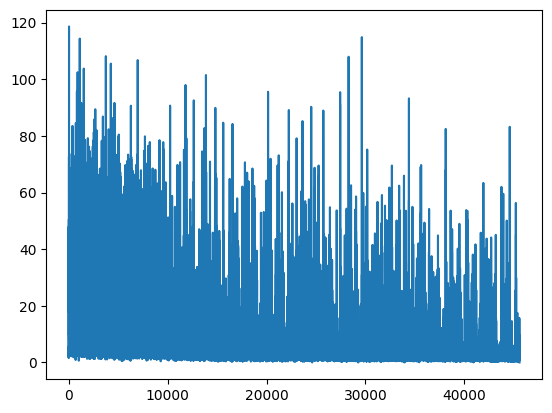

In [189]:
## MLP
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device ='cuda'
# model= nn.Sequential(
#     nn.Linear(4, 64),
#     nn.ReLU(),
#     nn.Linear(64, 16),
#     nn.ReLU(),
#     nn.Linear(16, 4),
#     nn.ReLU(),
#     nn.Linear(4,1),
# )

model= nn.Sequential(
    nn.Linear(4, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4,1),
)


loss_fn= nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

n_epochs = 20
X_train = torch.Tensor(np.array(X_train))
y_train = torch.Tensor(np.array(y_train))
X_test = torch.Tensor(np.array(X_test))
y_test = torch.Tensor(np.array(y_test))
loader =  data.DataLoader(data.TensorDataset(X_train, y_train), shuffle= True, batch_size = 8)
## train
loss_list = []
for epoch in tqdm(range(n_epochs)):
    model.train().to(device)
    for X_batch, y_batch in loader:
#         print(X_batch.shape, y_batch.shape)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_preds = model(X_batch)[:,0]  ## shape(8,1) to shape(8,)
#         print(y_preds)
        loss = loss_fn(y_preds, y_batch)
        loss_list.append(loss.cpu().detach().item())
#         print('Loss:', loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## evaluate with test dataset
model.eval().to(device)
# model_state = '../pt_files/mlp_s_20230731.pt'
# model.load_state_dict(torch.load(model_state, map_location=torch.device(device)))
with torch.no_grad():
    y_preds = model(X_test.to(device)).cpu()[:,0]  ## in cpu, shape(xxxx,1) to shape(xxxx,)
    print('MLP result with test data:')
    print_evaluate(y_test, y_preds)
# torch.save(model.state_dict(), '../pt_files/mlp_video'+video_sequence+'.pt')
print('model saved! in ../pt_files folder.')

plt.plot(range(len(loss_list)-1000),loss_list[1000:])

In [190]:
torch.save(model.state_dict(), '../pt_files/mlp_video'+video_sequence+'.pt')

In [12]:
model= nn.Sequential(
    nn.Linear(4, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4,1),
)

epoch=200
LR=0.0005
bs =8
MAE: 0.6931825
MSE: 0.71347225
RMSE: 0.84467286

#OR
model= nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4,1),
)

epoch=300
LR=0.0005
bs=8
MAE: 0.6606049
MSE: 0.69018406
RMSE: 0.8307732

## backup 

In [34]:
import pandas as pd
data =  pd.read_csv('../result/old_new.csv', index_col = 0)
data

,item,old_x,old_y,new_x,new_y,round,dist
0,0,95.00000,251.00000,95.00005,251.000000,0,2.500000e-09
1,1,710.00000,280.00000,709.72125,279.729460,0,1.508935e-01
2,2,224.00000,290.00000,224.00000,290.000000,0,0.000000e+00
3,3,1138.00000,286.00000,1138.00000,286.000000,0,0.000000e+00
4,4,1133.00000,293.00000,1133.00000,293.000000,0,0.000000e+00
...,...,...,...,...,...,...,...
23914,15,412.79263,282.96558,412.79617,282.966500,11,1.337800e-05
23915,16,714.55176,325.82420,714.11140,325.141720,11,6.596959e-01
23916,17,235.96973,38.06859,235.96764,38.067078,11,6.654244e-06
23917,18,337.32993,130.75073,337.33440,130.748050,11,2.716330e-05


(array([[1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01, 1.00000e+01,
         1.00000e+01, 1.00000e+01, 1.0

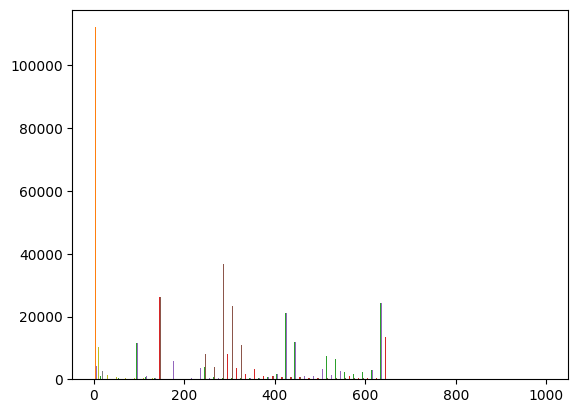

In [9]:
from matplotlib import pyplot as plt
plt.hist(data, bins =100, range=(1,1000))

In [78]:
import pandas as pd
data =  pd.read_csv('../result/old_new.csv', index_col = 0)
df =data[data['round']==0]
df['movement'] = (df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2 ## add a new column of distance
df.drop(columns = ['dist'], axis =1, inplace = True)
df= df[df['movement']>1]
df

/tmp/ipykernel_3205/1392922077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['movement'] = (df.new_x-df.old_x)**2 + (df.new_y-df.old_y)**2 ## add a new column of distance
/tmp/ipykernel_3205/1392922077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['dist'], axis =1, inplace = True)


,item,old_x,old_y,new_x,new_y,round,movement
5,5,588.00000,302.00000,587.18020,302.59240,0,1.023010
12,12,572.00000,307.00000,571.04880,307.70667,0,1.404164
25,5,587.18020,302.59240,586.26370,303.31396,0,1.360621
32,12,571.04880,307.70667,569.84827,308.45416,0,2.000014
52,12,569.84827,308.45416,568.83770,308.87054,0,1.194624
...,...,...,...,...,...,...,...
2264,17,295.35583,463.99756,285.18698,470.71643,0,148.548724
2282,17,285.18698,470.71643,274.44290,477.79858,0,165.592104
2300,17,274.44290,477.79858,263.24078,485.31863,0,182.038644
2318,17,263.24078,485.31863,251.24223,493.40356,0,209.331295


In [49]:
idx= df.index
idx

Int64Index([   5,   12,   25,   32,   52,   65,   72,   85,   92,   99,
            ...
            2174, 2192, 2210, 2228, 2246, 2264, 2282, 2300, 2318, 2336],
           dtype='int64', length=296)

In [51]:
idx[0]

5

In [103]:
df.index

Int64Index([8167, 8171, 8173, 8174, 8175, 8179, 8181, 8187, 8191, 8193,
            ...
            9521, 9527, 9529, 9531, 9533, 9534, 9535, 9538, 9539, 9541],
           dtype='int64', length=569)